<a href="https://colab.research.google.com/github/samanthamartinez-chem/BEDU/blob/master/Proyecto_Equipo_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Aviso antes de iniciar**
Es importante que si se va a correr el programa de corrido (sin darle click a cada pestaña) consideres que la primera parte del codigo es limpieza de datos y a lo largo del código estas tablas se van modificando para un mejor uso. Por eso te recomendamos correr **casilla por casilla**.


El **objetivo** de nuestro proyecto es comparar un método manual de limpieza y ordenamiento de datos respecto al uso de una librería y una API (bendito internet) que, en conjunto, lo hacen en menos pasos. Nos hemos inspirado en nuestro proyecto R que, habla sobre la creación de portafolios de inversión, más adelante podrás verlo.

#¡Bienvenido, y ponte cómodo!

Ocuparemos instalar las siguientes dependencias.

In [53]:
!pip install iexfinance
!pip install plotly --upgrade

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (5.0.0)


**Ocuparemos las siguientes librerías:**

In [54]:
import matplotlib.pyplot as plt # Esta librería es necesaria para el trabajo técnico de gráficos
import numpy as np
import pandas as pd
import pandas_datareader as pdr # Para obtener las bases de datos de internet 
import plotly.express as px # Para poder realizar diversos tipos de gráficas, en especial treemaps.
import seaborn as sns #Para poder realizar distintos tipos de gráficas
from iexfinance.stocks import Stock
from matplotlib.ticker import  FuncFormatter 
import nltk 
from nltk.corpus import stopwords 
import re
from nltk.sentiment import SentimentIntensityAnalyzer as SIA
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import spacy as sp
import math #Importamos math para poder hacer la raíz cuadrada de 252 para añadirla posteriormente a una variable. 
from scipy import stats
import random 
from sklearn.linear_model import LinearRegression

nltk.download('vader_lexicon')
nlps = sp.load('en')
plt.rc('figure', figsize=(17,13))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#Primera parte, arrancamos! 

Vamos a trabajar con datos de acciones del DowJones para conocer cómo podemos observar mediante algunos gráficos el comportamiento de su rendimiento y su riesgo, además de obtener algunas conclusiones. 

**Empresas Listadas en el DowJones**

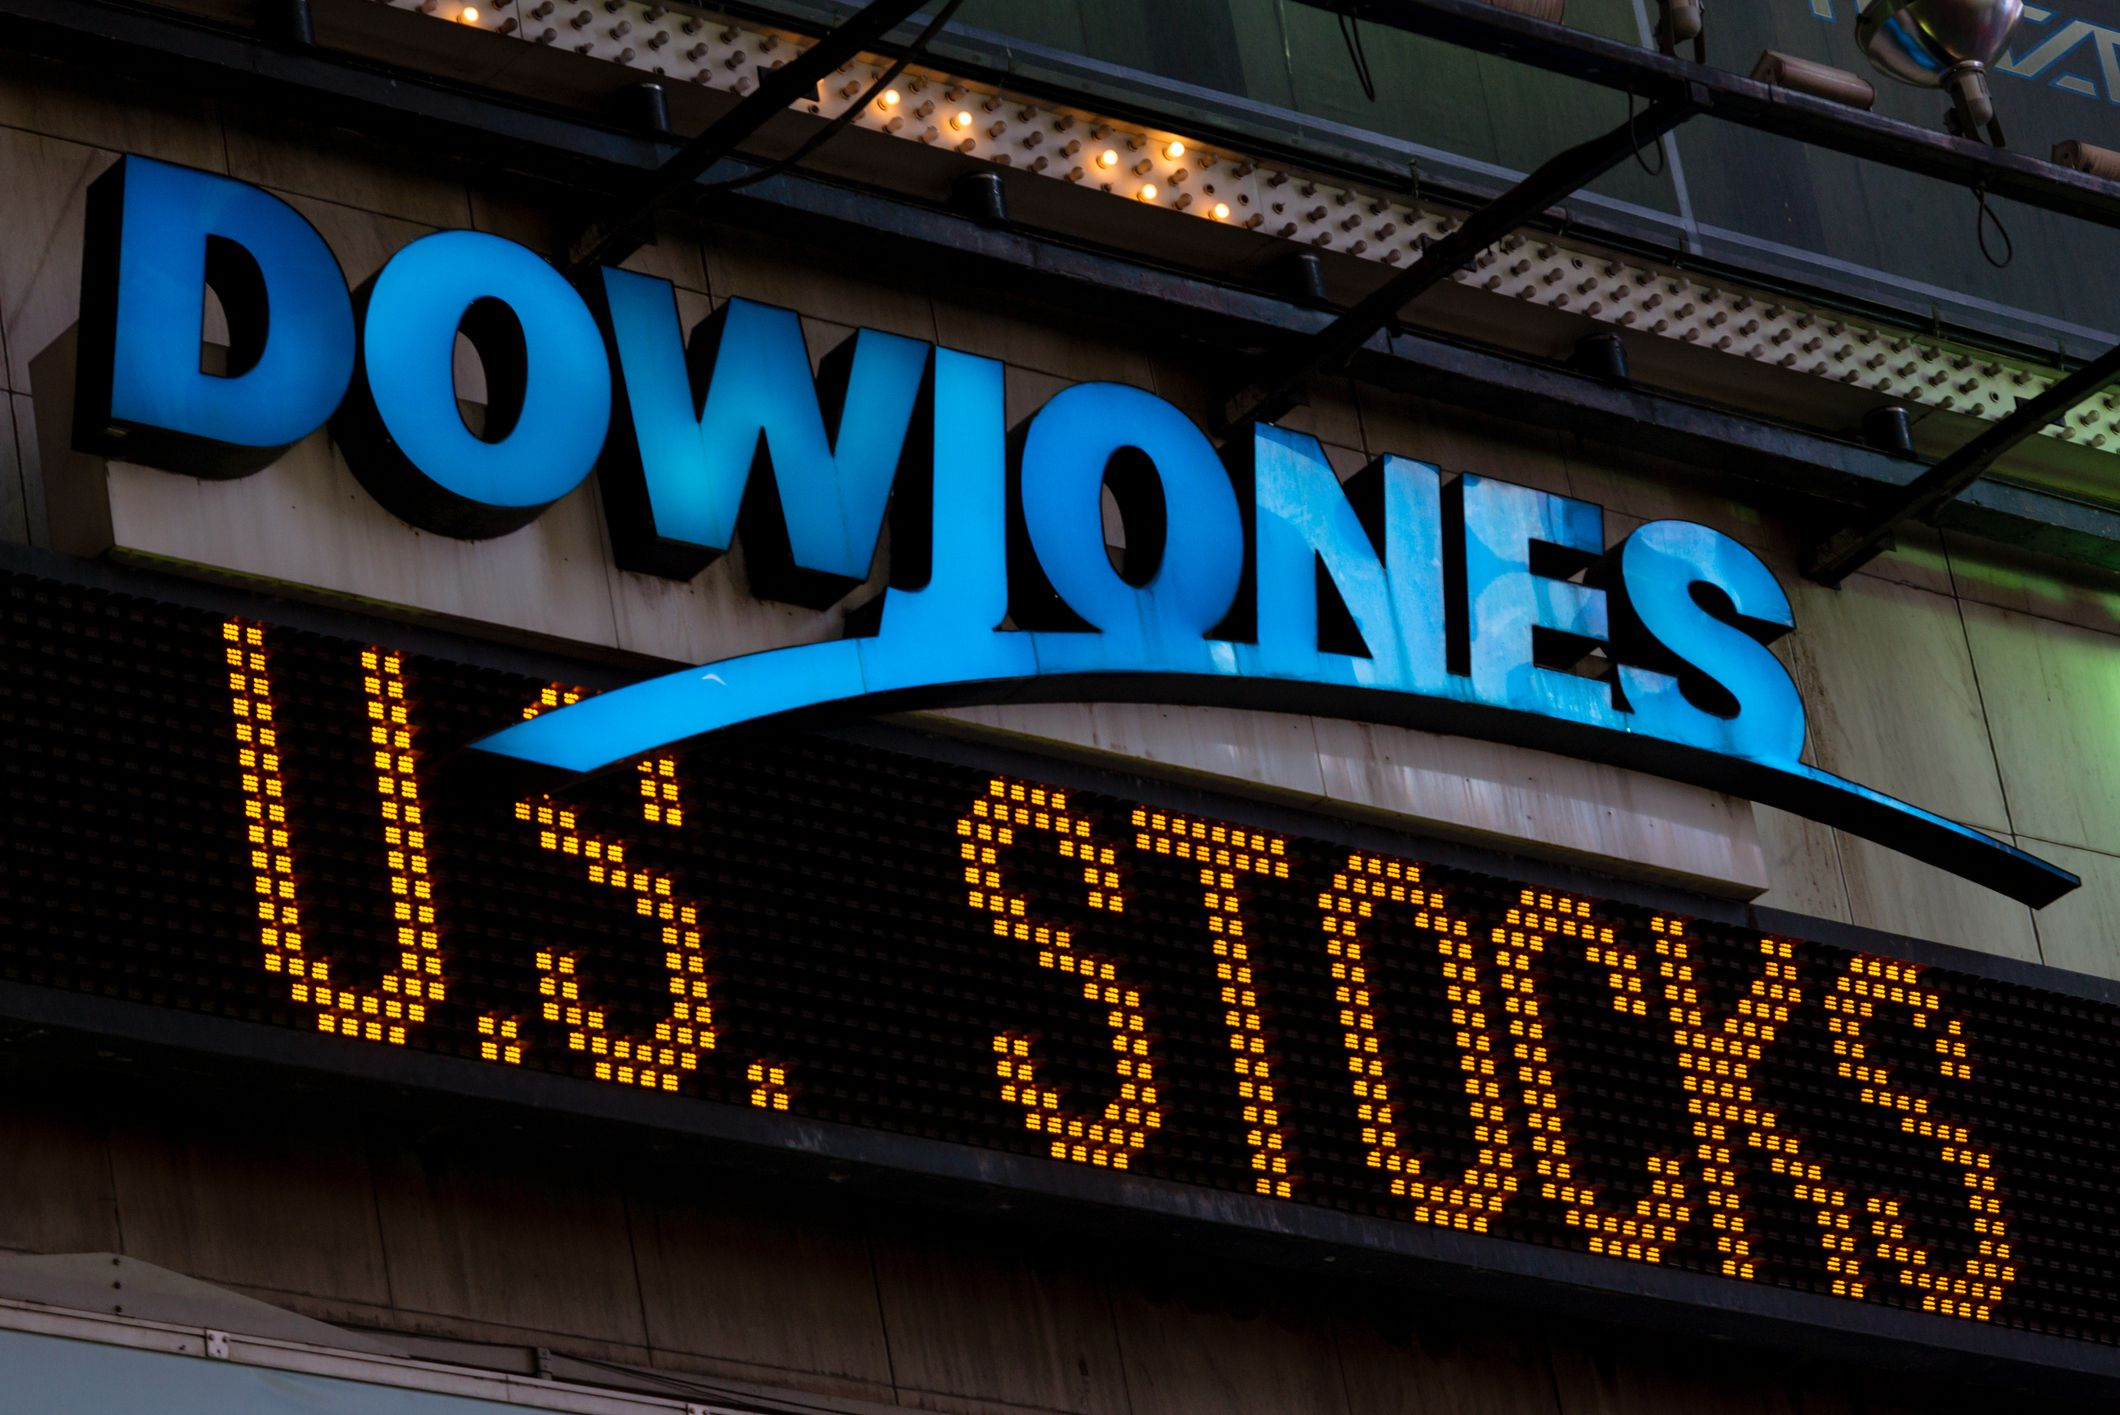

* PG | The Procter & Gamble Company
* CSCO | Cisco Systems, Inc.
* AXP | American Express Company
* UNH | UnitedHealth Group Incorporated
* MMM | 3M Company
* CRM | salesforce.com, inc.
* IBM | International Business Machines Corporation
* DIS | The Walt Disney Company 
* WMT | Walmart Inc.
* KO | The Coca-Cola Company	<
* JNJ | Johnson & Johnson
* HON | Honeywell International Inc.
* MCD | McDonald's Corporation
* VZ | Verizon Communications Inc.
* CAT | Caterpillar Inc.
* GS | The Goldman Sachs Group, Inc.
* INTC | Intel Corporation	
* MRK | Merck & Co., Inc. 
* V | Visa Inc. 
* NKE | NIKE, Inc. 
* HD | The Home Depot, Inc.
* AAPL | Apple Inc. 
* TRV | The Travelers Companies, Inc.	
* WBA | Walgreens Boots Alliance, Inc.
* JPM | JPMorgan Chase & Co.	
* DOW | Dow Inc.  ### No fue posible ocupar esta accion ya que no tiene el numero de observaciones requeridas
* AMGN | Amgen Inc 
* MSFT | Microsoft Corporation
* CVX | Chevron Corporation	
* BA | The Boeing Company 

**Para conocer un poco más sobre el DowJones utilizaremos una API con información diversa sobre el mismo.**

In [55]:
claves = ["PG","CSCO","AXP","UNH","MMM","CRM","IBM","DIS","WMT","KO","JNJ","HON","MCD","VZ","CAT","GS","INTC","MRK","V","NKE","HD","AAPL","TRV","WBA","JPM","AMGN","MSFT","CVX","BA"] 

In [56]:
companies = Stock(claves, output_format="pandas", token="pk_a3ba9037e44c496697b317b09bca4694")
companies_info = companies.get_company()
companies_info.head()

symbol             companyName  ... country        phone
PG       PG    Procter & Gamble Co.  ...      US  15139831100
CSCO   CSCO     Cisco Systems, Inc.  ...    None         None
AXP     AXP    American Express Co.  ...      US  12126402000
UNH     UNH  Unitedhealth Group Inc  ...      US  19529361300
MMM     MMM                  3M Co.  ...      US  16517331474

[5 rows x 20 columns]

**Analizando la información arrojada por la API podemos darnos cuenta de que faltan diversos datos que utilizaremos para realizar nuestro estudio. Por esta razón optamos por llenar dichos valores con la información que nos hace falta.**

En la siguiente celda, añadimos las ciudades y estados faltantes. Los encontramos de manera manual.

In [57]:
companies_info.at['CSCO', 'state'] = 'California'
companies_info.at['CVX', 'state'] = 'California'
companies_info.at['DIS', 'state'] = 'California'

companies_info.at['CSCO', 'city'] = 'San José'
companies_info.at['CVX', 'city'] = 'San Ramón'
companies_info.at['DIS', 'city'] = 'Los Ángeles'

companies_info.at['DIS', 'sector'] = 'Management of Companies and Enterprises'

Para conocer un poco sobre la geografía de las empresas pertenecientes al DowJones, agrupamos los valores de estado y ciudad por nombre de compañía.

In [58]:
df_grouped = companies_info.groupby('companyName')[['state', 'city', 'symbol']].max()
df_grouped['count'] = 1
df_grouped.head()

state           city symbol  count
companyName                                                  
3M Co.                 Minnesota     Saint Paul    MMM      1
AMGEN Inc.            California  Thousand Oaks   AMGN      1
American Express Co.    New York       New York    AXP      1
Apple Inc             California      Cupertino   AAPL      1
Boeing Co.              Illinois        Chicago     BA      1

**Advertencia:** Si no muestra el treemap es por la dependencia instalada plotly instalada previamente. **Por favor** reinicie el entorno de ejecución y vuelva a ejecutar todo el proyecto.

In [59]:
#Realizamos un treemap para ver donde se encuentra la mayor concentración de empresas del DowJones
fig = px.treemap(df_grouped, path=['state', 'city', 'symbol'], values='count')

fig.show()

**Ahora para que sea mas facil cuantificar la industria realizaremos una grafica de barra combinada**

In [60]:
#Agrupamos por compañia para poder determinar al sector que pertence 
df_grouped = companies_info.groupby('companyName')['state', 'sector'].max() 
df_grouped['count'] = 1
df_grouped.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



state  ... count
companyName                       ...      
3M Co.                 Minnesota  ...     1
AMGEN Inc.            California  ...     1
American Express Co.    New York  ...     1
Apple Inc             California  ...     1
Boeing Co.              Illinois  ...     1

[5 rows x 3 columns]

In [61]:
value_counts = df_grouped.groupby(['state', 'sector'])['count'].sum()
value_counts

state           sector                                          
Arkansas        Retail Trade                                        1
California      Information                                         2
                Management of Companies and Enterprises             1
                Manufacturing                                       5
Georgia         Manufacturing                                       1
                Retail Trade                                        1
Illinois        Accommodation and Food Services                     1
                Manufacturing                                       2
                Retail Trade                                        1
Minnesota       Finance and Insurance                               2
                Management of Companies and Enterprises             1
New Jersey      Manufacturing                                       2
New York        Finance and Insurance                               3
                Informati

In [62]:
#Convertimos a DataFrame 
value_counts = value_counts.unstack(1) 

value_counts

sector          Accommodation and Food Services  ...  Retail Trade
state                                            ...              
Arkansas                                    NaN  ...           1.0
California                                  NaN  ...           NaN
Georgia                                     NaN  ...           1.0
Illinois                                    1.0  ...           1.0
Minnesota                                   NaN  ...           NaN
New Jersey                                  NaN  ...           NaN
New York                                    NaN  ...           NaN
North Carolina                              NaN  ...           NaN
Ohio                                        NaN  ...           NaN
Oregon                                      NaN  ...           NaN
Washington                                  NaN  ...           NaN

[11 rows x 7 columns]

In [63]:
#Los numeros en NA los llenamos para que se pueda graficar correctamente 
value_counts = value_counts.fillna(0)
value_counts

sector          Accommodation and Food Services  ...  Retail Trade
state                                            ...              
Arkansas                                    0.0  ...           1.0
California                                  0.0  ...           0.0
Georgia                                     0.0  ...           1.0
Illinois                                    1.0  ...           1.0
Minnesota                                   0.0  ...           0.0
New Jersey                                  0.0  ...           0.0
New York                                    0.0  ...           0.0
North Carolina                              0.0  ...           0.0
Ohio                                        0.0  ...           0.0
Oregon                                      0.0  ...           0.0
Washington                                  0.0  ...           0.0

[11 rows x 7 columns]

**Como podemos observar en la grafica de abajo la mayoria de las acciones se encuentran en California** 

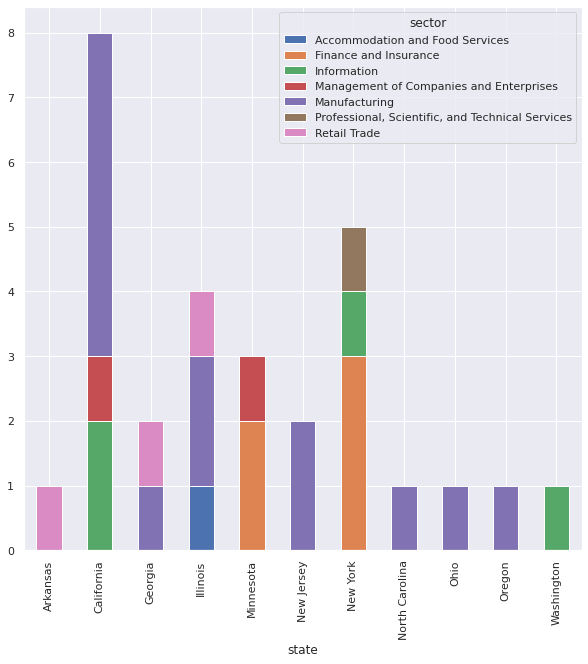

In [64]:
sns.set(rc={'figure.figsize':(10,10)})
value_counts.plot(kind='bar', stacked=True)

**Cargamos las bases de datos**

In [65]:
precios_PG = "https://query1.finance.yahoo.com/v7/finance/download/PG?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_CSCO = "https://query1.finance.yahoo.com/v7/finance/download/CSCO?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_AXP = "https://query1.finance.yahoo.com/v7/finance/download/AXP?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_UNH = "https://query1.finance.yahoo.com/v7/finance/download/UNH?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_MMM = "https://query1.finance.yahoo.com/v7/finance/download/MMM?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_CRM = "https://query1.finance.yahoo.com/v7/finance/download/CRM?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_IBM = "https://query1.finance.yahoo.com/v7/finance/download/IBM?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_DIS = "https://query1.finance.yahoo.com/v7/finance/download/DIS?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_WMT = "https://query1.finance.yahoo.com/v7/finance/download/WMT?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_KO = "https://query1.finance.yahoo.com/v7/finance/download/KO?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_JNJ = "https://query1.finance.yahoo.com/v7/finance/download/JNJ?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_HON = "https://query1.finance.yahoo.com/v7/finance/download/HON?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_MCD = "https://query1.finance.yahoo.com/v7/finance/download/MCD?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_VZ = "https://query1.finance.yahoo.com/v7/finance/download/VZ?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_CAT = "https://query1.finance.yahoo.com/v7/finance/download/CAT?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_GS = "https://query1.finance.yahoo.com/v7/finance/download/GS?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_INTC = "https://query1.finance.yahoo.com/v7/finance/download/INTC?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_MRK = "https://query1.finance.yahoo.com/v7/finance/download/MRK?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_V = "https://query1.finance.yahoo.com/v7/finance/download/V?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_NKE = "https://query1.finance.yahoo.com/v7/finance/download/NKE?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_HD = "https://query1.finance.yahoo.com/v7/finance/download/HD?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_AAPL = "https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_TRV = "https://query1.finance.yahoo.com/v7/finance/download/TRV?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_WBA = "https://query1.finance.yahoo.com/v7/finance/download/WBA?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_JPM = "https://query1.finance.yahoo.com/v7/finance/download/JPM?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_AMGN = "https://query1.finance.yahoo.com/v7/finance/download/AMGN?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_MSFT = "https://query1.finance.yahoo.com/v7/finance/download/MSFT?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_CVX = "https://query1.finance.yahoo.com/v7/finance/download/CVX?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"
precios_BA = "https://query1.finance.yahoo.com/v7/finance/download/BA?period1=1483228800&period2=1615161600&interval=1d&events=history&includeAdjustedClose=true"


# **Limpieza**

**Lo que queremos hacer, es un dataframe que contenga los precios de cierre del día de las acciones, pero necesitamos hacer algunos pasos de limpieza para lograrlo.**


Vamos a juntar en una lista las claves de pizarra, para no tener que cargarlos uno por uno manualmente:

In [66]:
claves_pizarra = [precios_PG, precios_CSCO, precios_AXP, precios_UNH, precios_MMM, precios_CRM, precios_IBM, precios_DIS, precios_WMT, precios_KO, precios_JNJ, precios_HON, precios_MCD, precios_VZ, precios_CAT, precios_GS, 
                      precios_INTC, precios_MRK, precios_V, precios_NKE, precios_HD, precios_AAPL, precios_TRV, precios_WBA, precios_JPM, precios_AMGN, precios_MSFT, precios_CVX, precios_BA]

La funcion pd.read_csv no lee listas, así que haremos un loop para extraer los datos de las acciones, el resultado serán dataframes para cada acción, pero contendrán los valores de precio máximos, mínimos, de apertura y de cierre por día: 

In [67]:
precios_downjones  = [] 

for filename in claves_pizarra: 
    data = pd.read_csv(filename, index_col="Date")
    precios_downjones.append(data)

Ahora uniremos los dataframes de manera horizontal, porque queremos visualizar los datos de las empresas por día:

In [68]:
frame = pd.concat(precios_downjones, axis=1) 

Seleccionamos solo las columnas de precio de cierre 

In [69]:
precios_cierre = frame["Close"] 

In [70]:
precios_cierre 

Close      Close  ...       Close       Close
Date                               ...                        
2017-01-03   84.199997  30.540001  ...  117.849998  156.970001
2017-01-04   84.500000  30.100000  ...  117.820000  158.619995
2017-01-05   85.059998  30.170000  ...  117.309998  158.710007
2017-01-06   85.029999  30.230000  ...  116.839996  159.100006
2017-01-09   84.400002  30.180000  ...  115.839996  158.320007
...                ...        ...  ...         ...         ...
2021-03-01  124.290001  45.919998  ...  102.050003  224.389999
2021-03-02  123.900002  45.520000  ...  102.440002  223.139999
2021-03-03  123.160004  45.130001  ...  103.589996  228.559998
2021-03-04  122.150002  44.560001  ...  104.500000  224.710007
2021-03-05  125.980003  46.250000  ...  109.000000  223.220001

[1050 rows x 29 columns]

**Como pudiste observar, las columnas del dataframe dicen "Close", aún no sabemos a qué acción se refiere. Vamos a cambiar el nombre de las columnas, para eso haremos:**

1) Una serie con los nombres de las acciones:

In [71]:
titulos = ["PG","CSCO","AXP","UNH","MMM","CRM","IBM","DIS","WMT","KO","JNJ","HON","MCD","VZ","CAT","GS","INTC","MRK","V","NKE","HD","AAPL","TRV","WBA","JPM","AMGN","MSFT","CVX","BA"] 

2) Usar esa serie como títulos de las columnas:

In [72]:
precios_cierre.columns = titulos 


¡Y listo!

In [73]:
precios_cierre

PG       CSCO  ...         CVX          BA
Date                               ...                        
2017-01-03   84.199997  30.540001  ...  117.849998  156.970001
2017-01-04   84.500000  30.100000  ...  117.820000  158.619995
2017-01-05   85.059998  30.170000  ...  117.309998  158.710007
2017-01-06   85.029999  30.230000  ...  116.839996  159.100006
2017-01-09   84.400002  30.180000  ...  115.839996  158.320007
...                ...        ...  ...         ...         ...
2021-03-01  124.290001  45.919998  ...  102.050003  224.389999
2021-03-02  123.900002  45.520000  ...  102.440002  223.139999
2021-03-03  123.160004  45.130001  ...  103.589996  228.559998
2021-03-04  122.150002  44.560001  ...  104.500000  224.710007
2021-03-05  125.980003  46.250000  ...  109.000000  223.220001

[1050 rows x 29 columns]

**Ahora, crearemos una función que expresa (mediante un porcentaje) la relación entre el precio del cierre del día y el precio del cierre del día anterior. En otras palabras, el rendimiento de la acción:**

 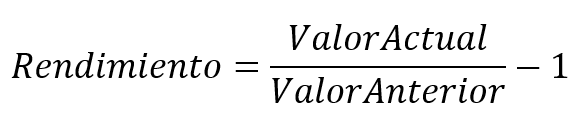

In [74]:
def porcentaje(accion):

      return  (accion/accion.shift(1))-1


**Con la función apply, aplicaremos la función a todo nuestro dataframe de precios de cierre.**

In [75]:
rendimientos_de_precio_cierre = precios_cierre.apply(porcentaje)

**Como podemos notar, en la primera fila tenemos NANs, porque la función necesita dividir entre los valores anteriores a este y no existen:**

In [76]:
rendimientos_de_precio_cierre

PG      CSCO       AXP  ...      MSFT       CVX        BA
Date                                      ...                              
2017-01-03       NaN       NaN       NaN  ...       NaN       NaN       NaN
2017-01-04  0.003563 -0.014407  0.012077  ... -0.004474 -0.000255  0.010512
2017-01-05  0.006627  0.002326 -0.012326  ...  0.000000 -0.004329  0.000567
2017-01-06 -0.000353  0.001989  0.001992  ...  0.008668 -0.004006  0.002457
2017-01-09 -0.007409 -0.001654  0.005168  ... -0.003183 -0.008559 -0.004903
...              ...       ...       ...  ...       ...       ...       ...
2021-03-01  0.006152  0.023401  0.025507  ...  0.019623  0.020500  0.058393
2021-03-02 -0.003138 -0.008711  0.003893  ... -0.012957  0.003822 -0.005571
2021-03-03 -0.005973 -0.008568  0.023986  ... -0.026981  0.011226  0.024290
2021-03-04 -0.008201 -0.012630  0.000631  ... -0.003647  0.008785 -0.016845
2021-03-05  0.031355  0.037926  0.032590  ...  0.021479  0.043062 -0.006631

[1050 rows x 29 columns]

1) Vamos a verificar que solo nos genero un NAN por acción, sumándolos por columnas: 

In [77]:
rendimientos_de_precio_cierre.isna().sum(axis=0) 
#En este caso pusimos axis 0 ya que sabiamos que los NAN estaba en la primera fila y con esto nos aseguramos 
#ya que si exisitira alguno saldria 2, y de ser asi significa que existe en otra fila (apesar de que estamos calculando columnas)

PG      1
CSCO    1
AXP     1
UNH     1
MMM     1
CRM     1
IBM     1
DIS     1
WMT     1
KO      1
JNJ     1
HON     1
MCD     1
VZ      1
CAT     1
GS      1
INTC    1
MRK     1
V       1
NKE     1
HD      1
AAPL    1
TRV     1
WBA     1
JPM     1
AMGN    1
MSFT    1
CVX     1
BA      1
dtype: int64

2) Ahora que estamos seguros, vamos a quitarlos:

In [78]:
limpios_rendimientos_cierre = rendimientos_de_precio_cierre.dropna(axis=0, how="any")

3) Una última checadita antes de continuar no hace daño:

In [79]:
limpios_rendimientos_cierre.isna().sum(axis=0)


PG      0
CSCO    0
AXP     0
UNH     0
MMM     0
CRM     0
IBM     0
DIS     0
WMT     0
KO      0
JNJ     0
HON     0
MCD     0
VZ      0
CAT     0
GS      0
INTC    0
MRK     0
V       0
NKE     0
HD      0
AAPL    0
TRV     0
WBA     0
JPM     0
AMGN    0
MSFT    0
CVX     0
BA      0
dtype: int64

In [80]:
limpios_rendimientos_cierre

PG      CSCO       AXP  ...      MSFT       CVX        BA
Date                                      ...                              
2017-01-04  0.003563 -0.014407  0.012077  ... -0.004474 -0.000255  0.010512
2017-01-05  0.006627  0.002326 -0.012326  ...  0.000000 -0.004329  0.000567
2017-01-06 -0.000353  0.001989  0.001992  ...  0.008668 -0.004006  0.002457
2017-01-09 -0.007409 -0.001654  0.005168  ... -0.003183 -0.008559 -0.004903
2017-01-10 -0.010782  0.006627  0.010414  ... -0.000319 -0.007597  0.004737
...              ...       ...       ...  ...       ...       ...       ...
2021-03-01  0.006152  0.023401  0.025507  ...  0.019623  0.020500  0.058393
2021-03-02 -0.003138 -0.008711  0.003893  ... -0.012957  0.003822 -0.005571
2021-03-03 -0.005973 -0.008568  0.023986  ... -0.026981  0.011226  0.024290
2021-03-04 -0.008201 -0.012630  0.000631  ... -0.003647  0.008785 -0.016845
2021-03-05  0.031355  0.037926  0.032590  ...  0.021479  0.043062 -0.006631

[1049 rows x 29 columns]

#Ahora que tenemos nuestros datos limpios, están listos para usarse y responder algunas preguntas, ¡hagámoslo!

**¿Cómo podemos predecir cuál será el rendimiento anual de una acción?**

Sacamos el retorno esperado



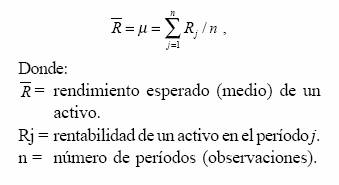

A continuación, obtenemos el promedio de los rendimientos de las acciones. Lo multiplicamos por 252 porque estamos contando días festivos ni fines de semana. 

In [81]:
retorno = limpios_rendimientos_cierre.mean() * 252
retorno


PG      0.119409
CSCO    0.140299
AXP     0.223987
UNH     0.229186
MMM     0.038606
CRM     0.322543
IBM    -0.036152
DIS     0.184725
WMT     0.177970
KO      0.069516
JNJ     0.094182
HON     0.183367
MCD     0.162093
VZ      0.026019
CAT     0.257338
GS      0.126991
INTC    0.187056
MRK     0.071900
V       0.276445
NKE     0.269296
HD      0.189482
AAPL    0.394363
TRV     0.096544
WBA    -0.082737
JPM     0.181662
AMGN    0.132988
MSFT    0.355940
CVX     0.042254
BA      0.206155
dtype: float64

*La siguiente celda solo muestra el factor unitario del retorno, pero no son datos que seguiremos usando*

In [82]:
prueba1111 = limpios_rendimientos_cierre.mean()

In [83]:
prueba1111

PG      0.000474
CSCO    0.000557
AXP     0.000889
UNH     0.000909
MMM     0.000153
CRM     0.001280
IBM    -0.000143
DIS     0.000733
WMT     0.000706
KO      0.000276
JNJ     0.000374
HON     0.000728
MCD     0.000643
VZ      0.000103
CAT     0.001021
GS      0.000504
INTC    0.000742
MRK     0.000285
V       0.001097
NKE     0.001069
HD      0.000752
AAPL    0.001565
TRV     0.000383
WBA    -0.000328
JPM     0.000721
AMGN    0.000528
MSFT    0.001412
CVX     0.000168
BA      0.000818
dtype: float64

Creamos el dataframe retorno partiendo de la serie retorno_esperado convirtiéndola a dataframe usando .to_frame()

In [84]:
data_frame_retorno = retorno.to_frame()
data_frame_retorno.columns = ['retorno'] 


Mostramos la tabla

In [85]:
data_frame_retorno

retorno
PG    0.119409
CSCO  0.140299
AXP   0.223987
UNH   0.229186
MMM   0.038606
CRM   0.322543
IBM  -0.036152
DIS   0.184725
WMT   0.177970
KO    0.069516
JNJ   0.094182
HON   0.183367
MCD   0.162093
VZ    0.026019
CAT   0.257338
GS    0.126991
INTC  0.187056
MRK   0.071900
V     0.276445
NKE   0.269296
HD    0.189482
AAPL  0.394363
TRV   0.096544
WBA  -0.082737
JPM   0.181662
AMGN  0.132988
MSFT  0.355940
CVX   0.042254
BA    0.206155

**¿Cuales son las top 5 empresas de rendimiento esperado?**

In [86]:
data_frame_retorno.sort_values("retorno", ascending=False).head(5)

retorno
AAPL  0.394363
MSFT  0.355940
CRM   0.322543
V     0.276445
NKE   0.269296

**¿En que año, en promedio, se generaron los mayores rendimientos el DowJones?**

---




Para contestar esa pregunta es necesario agrupar los datos por año

In [87]:
# Extraer el index (fechas) 
dates = pd.to_datetime(limpios_rendimientos_cierre.index)
# Acceder sólo a los años
dates.year

Int64Index([2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
            ...
            2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021, 2021],
           dtype='int64', name='Date', length=1049)

In [88]:
# Agrupar por los años
valores = limpios_rendimientos_cierre.groupby(dates.year).sum()
valores

PG      CSCO       AXP  ...      MSFT       CVX        BA
Date                                ...                              
2017  0.093204  0.239007  0.284633  ...  0.323508  0.070767  0.646810
2018  0.019553  0.158301 -0.012090  ...  0.211476 -0.111406  0.138588
2019  0.320411  0.131739  0.281751  ...  0.460040  0.119483  0.051926
2020  0.160516  0.018275  0.171115  ...  0.440715 -0.166520 -0.036776
2021 -0.096622  0.036698  0.206981  ...  0.045929  0.263568  0.057613

[5 rows x 29 columns]

In [89]:
#Respondemos la pregunta 
rendimientos_por_anio = valores.mean(axis=1)*100

rendimientos_por_anio[rendimientos_por_anio == rendimientos_por_anio.max()]

# El rendimientos esta en % por lo que seria el total 

Date
2019    22.65197
dtype: float64

**¿En que año, en promedio, se generaron los peores rendimientos el DowJones?**

In [90]:
rendimientos_por_anio[rendimientos_por_anio == rendimientos_por_anio.min()]

# ¿Te sorprendes que no haya sido el 2020? En el 2018 fue un año muy malo para las empresas 
# ya que Estados Unidos se estaba teniando una "guerra comercial" con China

Date
2018    2.006955
dtype: float64

**¿Qué tal la pasaron las empresas con el COVIcho?**


In [91]:
valores_2020 = valores[valores.index == 2020]
valores_2020

PG      CSCO       AXP  ...      MSFT      CVX        BA
Date                                ...                             
2020  0.160516  0.018275  0.171115  ...  0.440715 -0.16652 -0.036776

[1 rows x 29 columns]

Podemos hacer una gráfica para observarlo mejor:

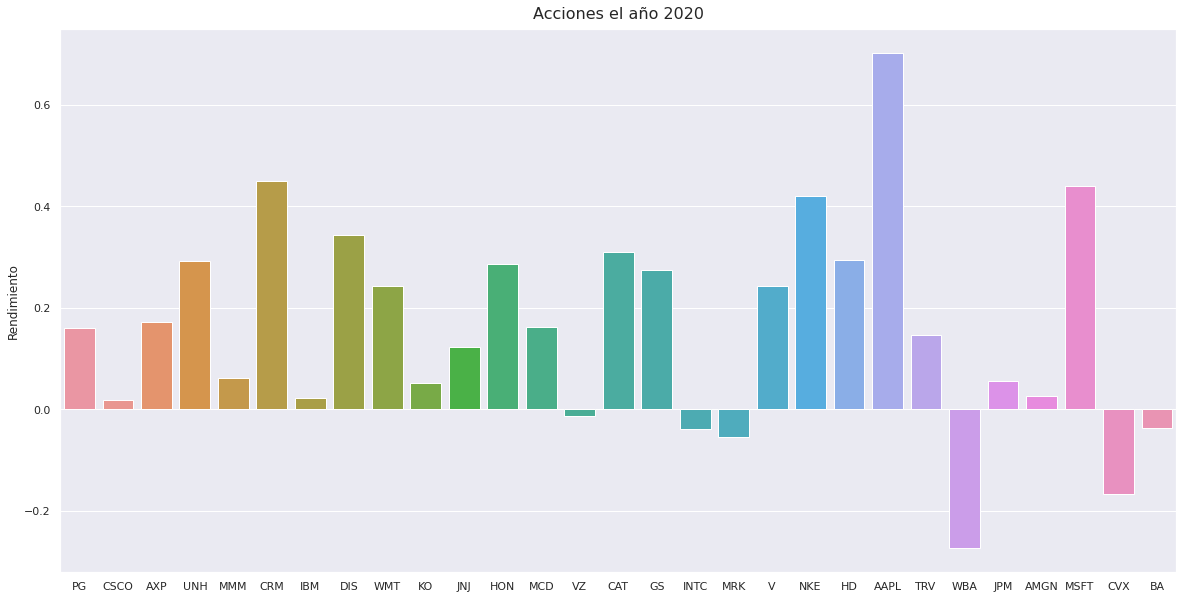

In [92]:
fig = plt.figure(figsize=(20,10))
ax = sns.barplot(x=valores_2020.columns, y=valores_2020.values[0])
ax.set_ylabel("Rendimiento")
ax.set_title("Acciones el año 2020", fontsize=16, pad=10);

**¿Qué acción genera mayor rendimiento promedio?** 

In [93]:
promedio_rendimiento_empresas = limpios_rendimientos_cierre.mean()
promedio_rendimiento_empresas[promedio_rendimiento_empresas == promedio_rendimiento_empresas.max()]

AAPL    0.001565
dtype: float64

In [94]:
promedio_rendimiento_empresas

PG      0.000474
CSCO    0.000557
AXP     0.000889
UNH     0.000909
MMM     0.000153
CRM     0.001280
IBM    -0.000143
DIS     0.000733
WMT     0.000706
KO      0.000276
JNJ     0.000374
HON     0.000728
MCD     0.000643
VZ      0.000103
CAT     0.001021
GS      0.000504
INTC    0.000742
MRK     0.000285
V       0.001097
NKE     0.001069
HD      0.000752
AAPL    0.001565
TRV     0.000383
WBA    -0.000328
JPM     0.000721
AMGN    0.000528
MSFT    0.001412
CVX     0.000168
BA      0.000818
dtype: float64

In [95]:
promedio_rendimiento_empresas.sort_values().tail(5)

NKE     0.001069
V       0.001097
CRM     0.001280
MSFT    0.001412
AAPL    0.001565
dtype: float64

#Ya vimos que la acción AAPL generó el mejor rendimiento, entonces, ¿nos conviene comprarla?

**No tan rápido vaquero, recuerda que las acciones son como la canción de elefante: te sube, te baja, te quita y a veces te lo da. Una acción que genera mucho rendimiento también puede tener mucho riesgo... o poco. Obviamente nos gustaría tener acciones que generen un rendimiento justo para el riesgo que estamos asumiento, y ese es el papel de algunos parámetros financieros como la relación de Sharpe.**

**¿Cuál es la mejor acción, considerando el riesgo rendimiento?** 

Utilizaremos la razón de sharpe (en la fórmula dice portafolios, pero lo usaremos para las acciones individuales). La acción que maximice esa relación es la que mayor rendimiento genera de acuerdo al riesgo asumido. 


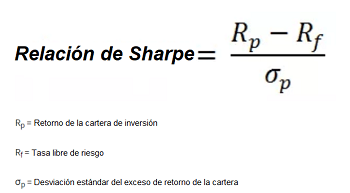


Para poder contestar ésto claramente, tenemos que agregar algunas columnas extras a la tabla de rendimientos, para poder agregar algunos columnas extras. Necesitamos un valor de tasa libre de riesgo (0.0164) y representa una acción que presenta una fluctuación mínima en su cotización histórica. Dicho valor es solo un punto de referencia.  

In [96]:
# Creamos la columna tasa_libre_de _riesgo con un valor estático de 1.64 a todas las columnas
data_frame_retorno['tasa_libre_de_riesgo'] = .0164

In [97]:
#Sacamos al desviación estándar del dataframe limpios_rendimientos_cierre con la función std()
desviacion = limpios_rendimientos_cierre.std() 

In [98]:
raiz = math.sqrt(252)

A continuación, multiplicaremos la desviación estándar obtenida por la raíz de 252 para **anualizar** la desviación estándar. Posteriormente la añadiremos a nuestro dataframe. 

In [99]:
desviacion =  (raiz * desviacion) 

In [100]:
#Agregamos la columna desviacion_estandar y añadimos los valores obtenidos en la línea anterior
data_frame_retorno['desviacion_estandar_anual'] = desviacion

In [101]:
data_frame_retorno

retorno  tasa_libre_de_riesgo  desviacion_estandar_anual
PG    0.119409                0.0164                   0.213100
CSCO  0.140299                0.0164                   0.284419
AXP   0.223987                0.0164                   0.358365
UNH   0.229186                0.0164                   0.300402
MMM   0.038606                0.0164                   0.263379
CRM   0.322543                0.0164                   0.347098
IBM  -0.036152                0.0164                   0.274581
DIS   0.184725                0.0164                   0.300559
WMT   0.177970                0.0164                   0.229981
KO    0.069516                0.0164                   0.212419
JNJ   0.094182                0.0164                   0.211816
HON   0.183367                0.0164                   0.264282
MCD   0.162093                0.0164                   0.244828
VZ    0.026019                0.0164                   0.199595
CAT   0.257338                0.0164                   0.323981
GS    0.126991                0.0164                   0.328812
INTC  0.187056                0.0164                   0.360394
MRK   0.071900                0.0164                   0.223356
V     0.276445                0.0164                   0.271810
NKE   0.269296                0.0164                   0.293620
HD    0.189482                0.0164                   0.268909
AAPL  0.394363                0.0164                   0.317556
TRV   0.096544                0.0164                   0.282535
WBA  -0.082737                0.0164                   0.323820
JPM   0.181662                0.0164                   0.316664
AMGN  0.132988                0.0164                   0.260888
MSFT  0.355940                0.0164                   0.287716
CVX   0.042254                0.0164                   0.347468
BA    0.206155                0.0164                   0.492952

Ahora sí utilizaremos la relación de Sharpe para elegir el mejor portafolio. Utilizaremos lambda, haremos referencia a las columnas del dataframe y agregaremos las relaciones de Sharpe como nueva columna. 

In [102]:
#Ya podemos obtener nuestro radio de Sharpe y utilizaremos lambda, hacemos referencia a las columnas del dataframe y por último la agregamos como nueva columna
data_frame_retorno['sharpe_ratio'] = data_frame_retorno.apply(lambda row: (row.retorno - row.tasa_libre_de_riesgo)/row.desviacion_estandar_anual, axis=1)


Ahora sí, podemos saber qué acción tiene el mayor radio de Sharpe 

In [103]:
df_sharpe_ratio= data_frame_retorno["sharpe_ratio"]
df_sharpe_ratio[df_sharpe_ratio == df_sharpe_ratio.max()]

AAPL    1.190224
Name: sharpe_ratio, dtype: float64

En este caso nos volvio a dar APPL por lo que podemos intuir que vamos a ver mas de este empresa en un buen % del portafolio

**¿Está muy bien hasta aquí, no? Pero no queremos comprar solo una acción, queremos comprar varias para que cuando una comience a caer, los retornos de las otras acciones no nos afecten tanto. Para eso son los portafolios de inversión, que dividen la inversión en el número de acciones con el fin de obtener las mejores combinaciones.**

## Pero, ¿te imaginas obtener el riesgo y el rendimiento de **tooodas** las combinciones de acciones posibles?

Claro que no, eso no va a pasar 

# **Lo que haremos es utilizar la API de Yahoo Finance y las librerías yfinance  y PyPortfolioOpt que harán las cosas más fáciles**

**Cargamos los datos utilizando el API Yahoo Finance** https://pypi.org/project/yfinance/

Instalamos

In [104]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 8.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=4e78b2c44c1ca8d57ffd02e3f21f44e4d2b3723d8ab60ed53520b553ad9010b3
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


Instalamos la libreria PyPortfolioOpt para el Portafolio que nos ayudara con  optimizacion https://pyportfolioopt.readthedocs.io/en/latest/

In [105]:
!pip install PyPortfolioOpt

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 1.3MB 9.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cvxpy: filename=cvxpy-1.1.13-cp37-cp37m-linux_x86_64.whl size=2736244 sha256=180c848dea620be72ed89379d2957fae9a299d153c6f41e6747f611501b971f0
  Stored in directory: /root/.cache/pip/wheels/f9/78/00/f29636789ee83434953b5442f16ec3f9834a68e7fd0393c220
Successfully built cvxpy
  Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


Importamos las librerias

In [106]:
import yfinance as yf 
import pypfopt
from pypfopt import plotting

Los primeros pasos son los mismos, listar los nombres de las acciones:






In [107]:
dowjones30 = ["PG","CSCO","AXP","UNH","MMM","CRM","IBM","DIS","WMT","KO","JNJ","HON","MCD","VZ","CAT","GS","INTC","MRK",
                "V","NKE","HD","AAPL","TRV","WBA","JPM","AMGN","MSFT","CVX","BA"]# Declaramos las claves de pizza para poder descargar los datos
               

In [108]:
dowjones30

['PG',
 'CSCO',
 'AXP',
 'UNH',
 'MMM',
 'CRM',
 'IBM',
 'DIS',
 'WMT',
 'KO',
 'JNJ',
 'HON',
 'MCD',
 'VZ',
 'CAT',
 'GS',
 'INTC',
 'MRK',
 'V',
 'NKE',
 'HD',
 'AAPL',
 'TRV',
 'WBA',
 'JPM',
 'AMGN',
 'MSFT',
 'CVX',
 'BA']

Descargamos los datos de la API de las mismas fechas que usamos en la primera sección:

In [109]:
obtener_datos = pdr.get_data_yahoo(dowjones30, start="2017-01-01", end="2021-03-05") # Por la comparacion de metologias utilizaremos fechas fijas

Obtenemos exclusivamente los precios de cierre

In [110]:
dowjones_precios_cierre = obtener_datos["Close"] #En esta caso solo requerimos los precios de cierre 
dowjones_precios_cierre

Symbols             PG       CSCO  ...         CVX          BA
Date                               ...                        
2017-01-03   84.199997  30.540001  ...  117.849998  156.970001
2017-01-04   84.500000  30.100000  ...  117.820000  158.619995
2017-01-05   85.059998  30.170000  ...  117.309998  158.710007
2017-01-06   85.029999  30.230000  ...  116.839996  159.100006
2017-01-09   84.400002  30.180000  ...  115.839996  158.320007
...                ...        ...  ...         ...         ...
2021-03-01  124.290001  45.919998  ...  102.050003  224.389999
2021-03-02  123.900002  45.520000  ...  102.440002  223.139999
2021-03-03  123.160004  45.130001  ...  103.589996  228.559998
2021-03-04  122.150002  44.560001  ...  104.500000  224.710007
2021-03-05  125.980003  46.250000  ...  109.000000  223.220001

[1050 rows x 29 columns]

Quitamos NAns y convertimos a dataframe 

In [111]:
dowjones_cierre = pd.DataFrame((dowjones_precios_cierre.dropna())) #Convertimos a dataframe y tambien nos quitamos los NA, en caso de que tuviera

Informacion del DataFrame

In [112]:
dowjones_cierre.info() # Verificar que los datos esten bien cargados 
dowjones_cierre.head() # Para poder identificar los datos 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1050 entries, 2017-01-03 to 2021-03-05
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PG      1050 non-null   float64
 1   CSCO    1050 non-null   float64
 2   AXP     1050 non-null   float64
 3   UNH     1050 non-null   float64
 4   MMM     1050 non-null   float64
 5   CRM     1050 non-null   float64
 6   IBM     1050 non-null   float64
 7   DIS     1050 non-null   float64
 8   WMT     1050 non-null   float64
 9   KO      1050 non-null   float64
 10  JNJ     1050 non-null   float64
 11  HON     1050 non-null   float64
 12  MCD     1050 non-null   float64
 13  VZ      1050 non-null   float64
 14  CAT     1050 non-null   float64
 15  GS      1050 non-null   float64
 16  INTC    1050 non-null   float64
 17  MRK     1050 non-null   float64
 18  V       1050 non-null   float64
 19  NKE     1050 non-null   float64
 20  HD      1050 non-null   float64
 21  AAPL    1050 non-nu

Symbols            PG       CSCO        AXP  ...       MSFT         CVX          BA
Date                                         ...                                   
2017-01-03  84.199997  30.540001  75.349998  ...  62.580002  117.849998  156.970001
2017-01-04  84.500000  30.100000  76.260002  ...  62.299999  117.820000  158.619995
2017-01-05  85.059998  30.170000  75.320000  ...  62.299999  117.309998  158.710007
2017-01-06  85.029999  30.230000  75.470001  ...  62.840000  116.839996  159.100006
2017-01-09  84.400002  30.180000  75.860001  ...  62.639999  115.839996  158.320007

[5 rows x 29 columns]

## **Ahora sí, vamos a ponernos un poquito técnicos. Observemos los siguentes gráficos:**

**Gráfico de precios del Dow Jones**

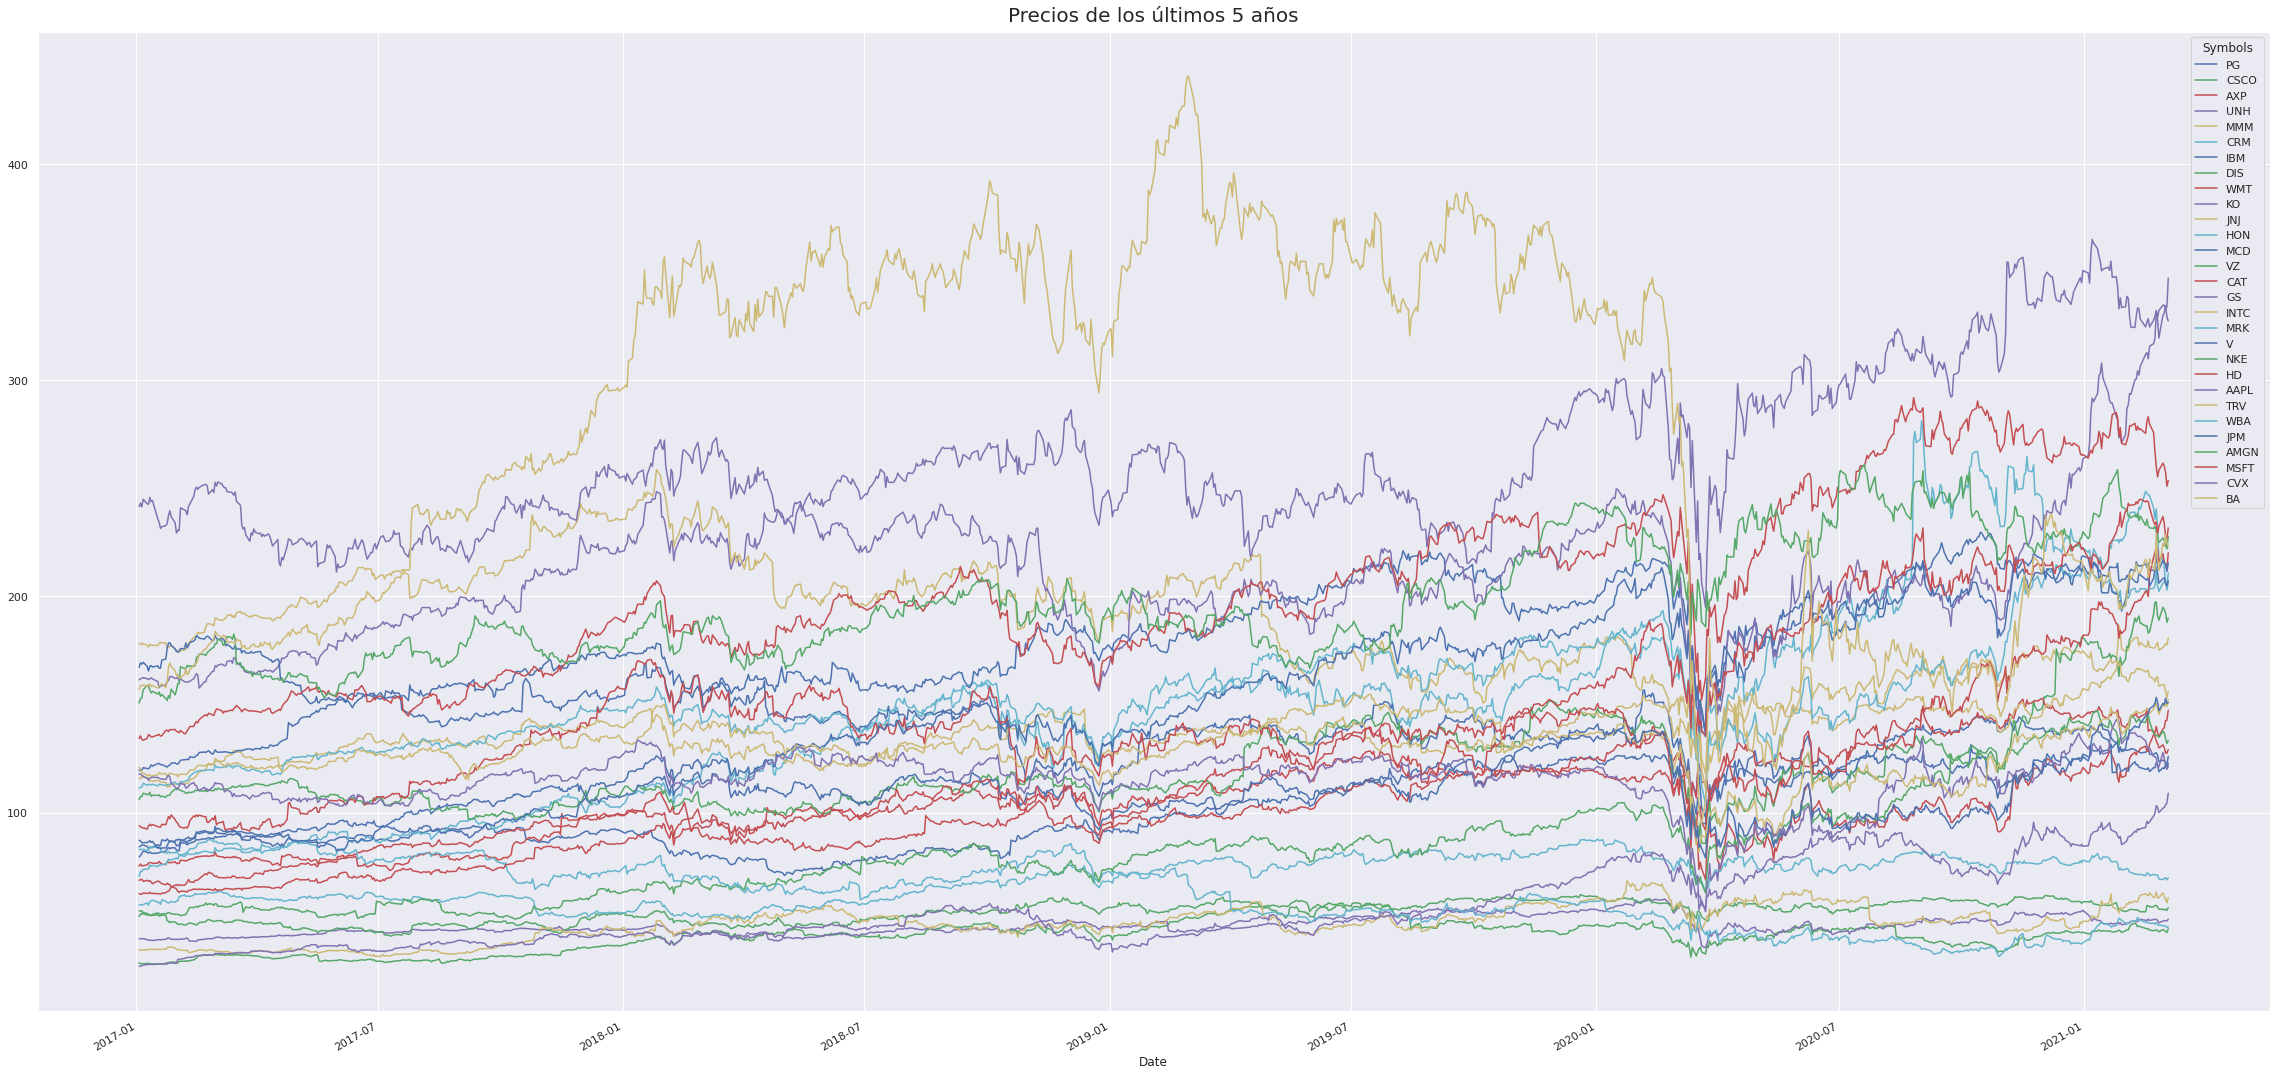

In [113]:
ax = dowjones_cierre.plot(figsize = (40,20)); # Se imprime una gráfica histórica de precios en los  ultimos 5 años, ahí tambien podemos notar como las acciones se fueron abajo cuando inicio la cuarentena 
ax.set_title("Precios de los últimos 5 años", fontsize=20, pad=10)
plt.show()

**Aquí podemos observar las líneas históricas de los precios de las acciones. ¿Puedes notar esa zona borrosa donde todas las accione caen? ¿Qué crees que ocurrió?**

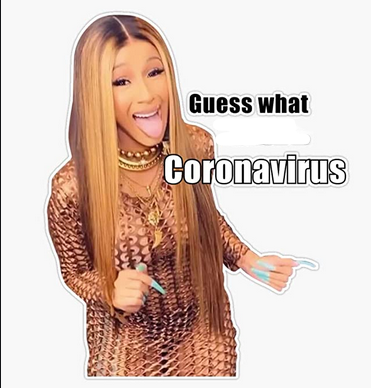

**Utilizamos pypfopt para obtener el Retorno Esperado**

**Este gráfico nos muestra el promedio de rendimientos anuales por acción, en otras palabras, nos permite predecir lo que esperaríamos recibir cada año de ellas.**

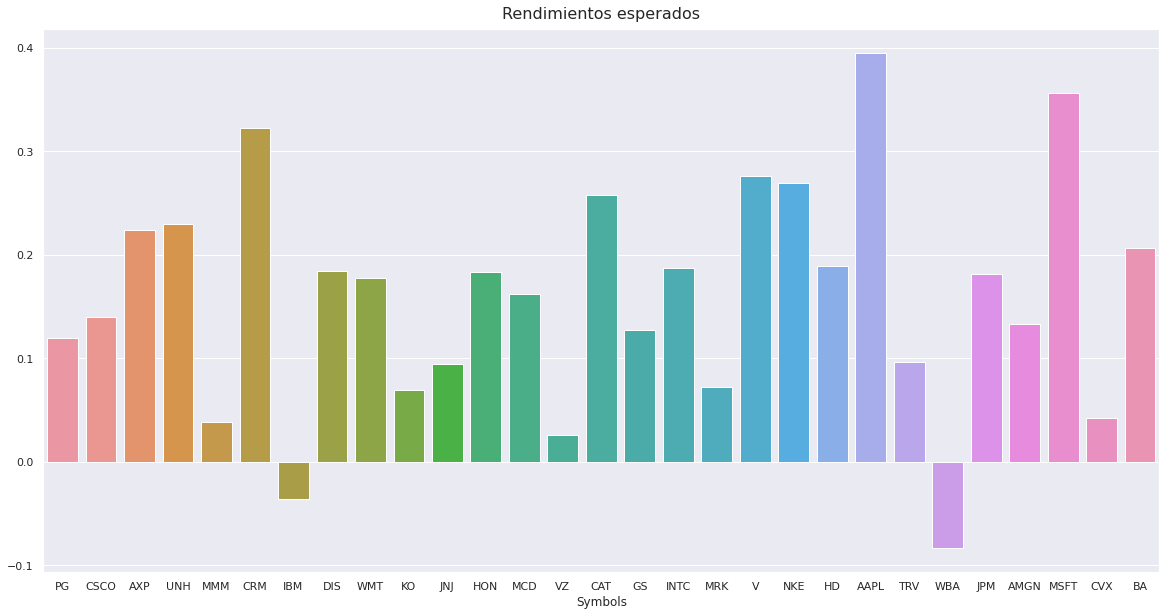

In [114]:
retorno_esperado = pypfopt.expected_returns.mean_historical_return(dowjones_cierre,compounding=False) # Con esta se hace un promedio de los precios anuales "Es lo que se espera recibir cada año"

# Mostramos una grafico de barras para hacer una comparacion con los rendimientos esperados 
fig = plt.figure(figsize=(20,10))
ax = sns.barplot(x=retorno_esperado.index, y=retorno_esperado.values)
ax.set_title("Rendimientos esperados", fontsize=16, pad=10);

**Ahora sí, es hora de ponernos serios y no andar arriesgándonos con una sola acción. Un portafolio nos da la oportunidad de combinar los porcentajes de inversión entre varias acciones para que tú decidas cuánto te vas a arriesgar.**

## **Cálculo de Portafolio**

**Utilizamos pipfopt para obtener la Covarianza** *Calcula la matriz de covarianza muestral anualizada de los rendimientos (diarios).* Recuerda que la covarianza es la que nos da información sobre la volatilidad entre empresas.

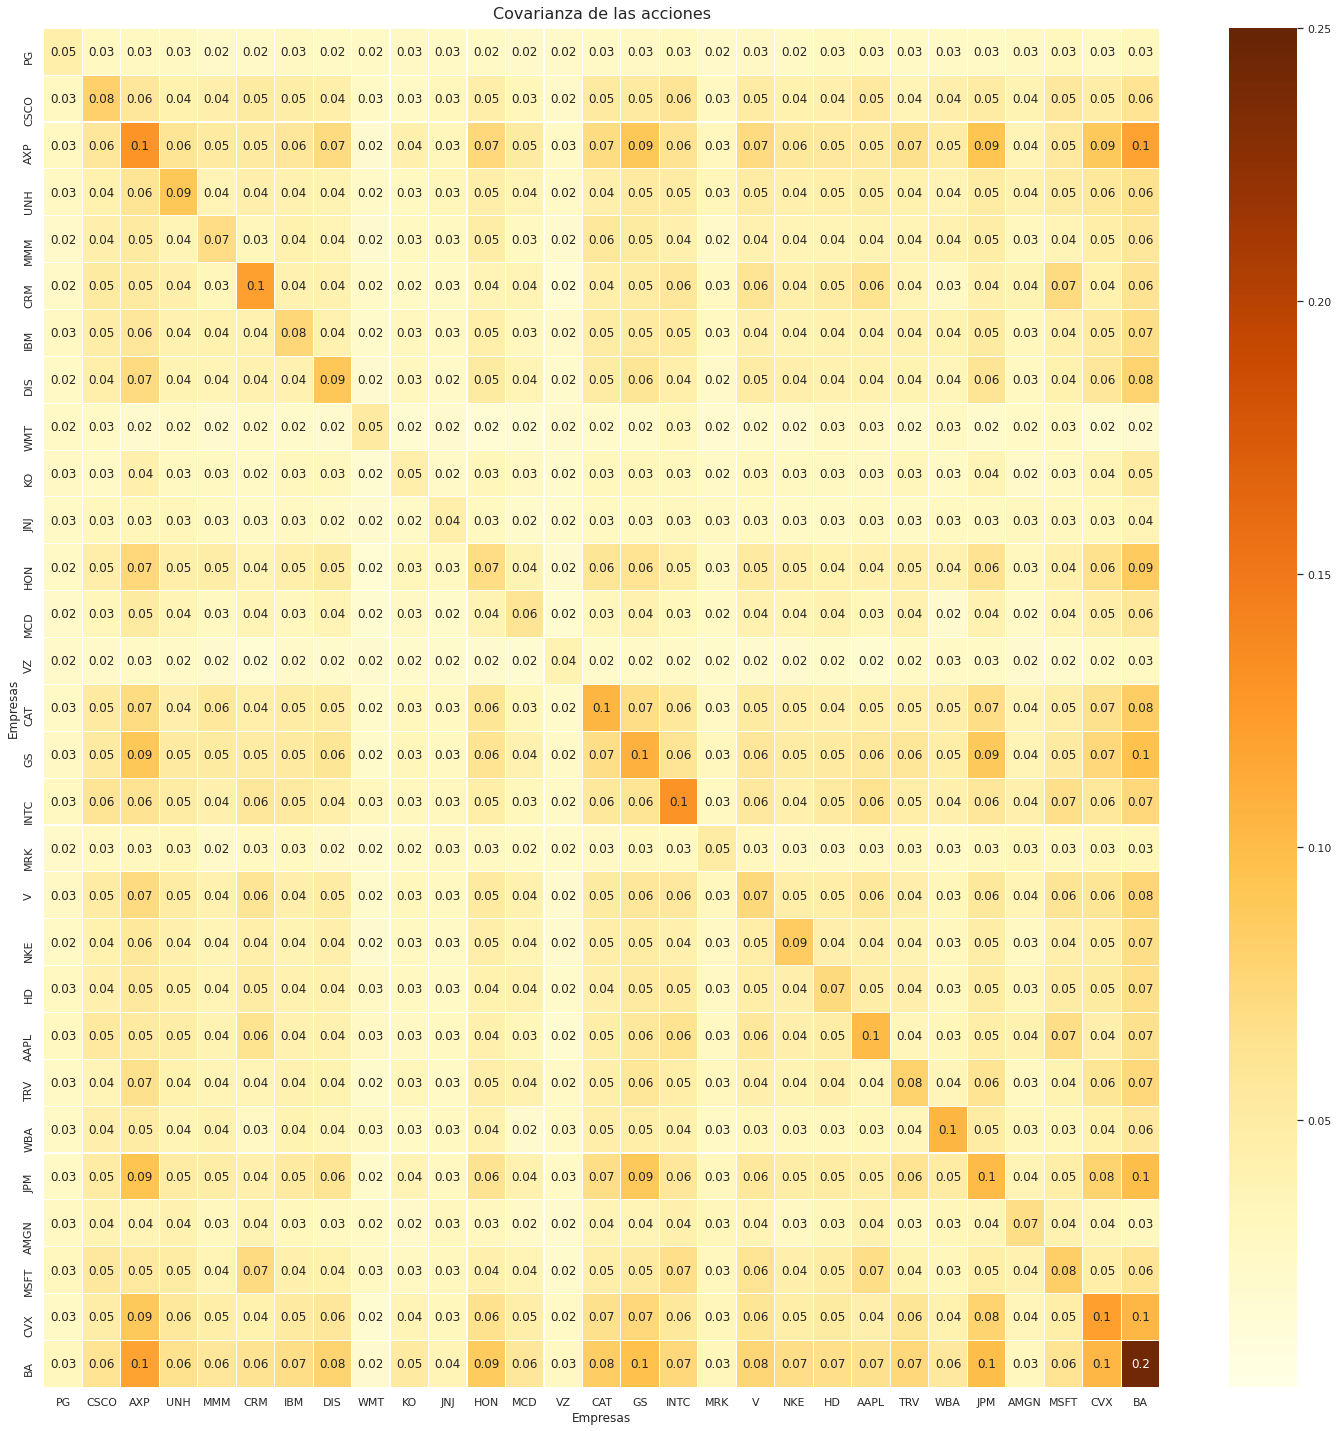

In [115]:
riesgo = pypfopt.risk_models.sample_cov(dowjones_cierre) # Con esta función cargamos la matriz de covarianza 

fig = plt.figure(figsize=(25,25))

ax = sns.heatmap(riesgo, cmap="YlOrBr", vmin=0.001, vmax=0.25, annot=True, linewidths=0.1, fmt=".1")
ax.set_title("Covarianza de las acciones", fontsize=16, pad=10)
ax.set_ylabel("Empresas")
ax.set_xlabel("Empresas");

**Frontera Efficiente**

In [116]:
frontera_eficiente = pypfopt.efficient_frontier.EfficientFrontier(retorno_esperado,riesgo, weight_bounds=(0,1)) # Con esta función generamos la frontera eficiente 


**Frontera eficiente**

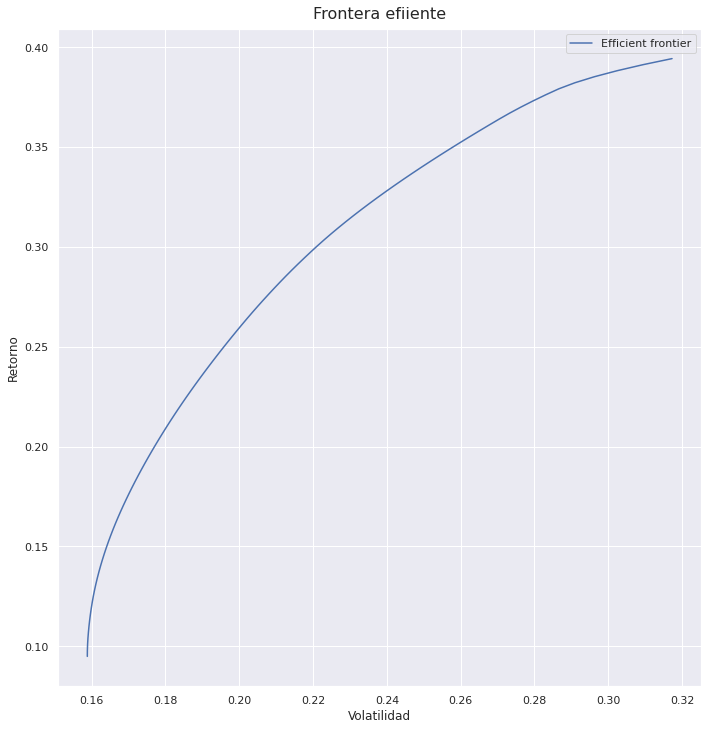

In [117]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(frontera_eficiente, ax=ax, show_assets=False); 
ax.set_ylabel("Retorno")
ax.set_xlabel("Volatilidad")
ax.set_title("Frontera efiiente", fontsize=16, pad=10);

**Ratio de Sharpe**

In [118]:
sharpe_ratio = frontera_eficiente.max_sharpe(risk_free_rate=(0.01644)) # Cargamos el ratio de Sharpe especificando la tasa libre de riesgo 
sharpe_ponderacion = frontera_eficiente.clean_weights() # Con esto hacemos que los puntos decimales sean más chicos 
sharpe_ponderacion
print(sharpe_ponderacion) # Nos muestra las ponderaciones de donde se ubica el ratio Sharpe 


OrderedDict([('PG', 0.0), ('CSCO', 0.0), ('AXP', 0.0), ('UNH', 0.0), ('MMM', 0.0), ('CRM', 0.0), ('IBM', 0.0), ('DIS', 0.0), ('WMT', 0.14337), ('KO', 0.0), ('JNJ', 0.0), ('HON', 0.0), ('MCD', 0.0), ('VZ', 0.0), ('CAT', 0.02916), ('GS', 0.0), ('INTC', 0.0), ('MRK', 0.0), ('V', 0.0), ('NKE', 0.13929), ('HD', 0.0), ('AAPL', 0.36583), ('TRV', 0.0), ('WBA', 0.0), ('JPM', 0.0), ('AMGN', 0.0), ('MSFT', 0.32236), ('CVX', 0.0), ('BA', 0.0)])


In [119]:
sharpe_ponderacion

OrderedDict([('PG', 0.0),
             ('CSCO', 0.0),
             ('AXP', 0.0),
             ('UNH', 0.0),
             ('MMM', 0.0),
             ('CRM', 0.0),
             ('IBM', 0.0),
             ('DIS', 0.0),
             ('WMT', 0.14337),
             ('KO', 0.0),
             ('JNJ', 0.0),
             ('HON', 0.0),
             ('MCD', 0.0),
             ('VZ', 0.0),
             ('CAT', 0.02916),
             ('GS', 0.0),
             ('INTC', 0.0),
             ('MRK', 0.0),
             ('V', 0.0),
             ('NKE', 0.13929),
             ('HD', 0.0),
             ('AAPL', 0.36583),
             ('TRV', 0.0),
             ('WBA', 0.0),
             ('JPM', 0.0),
             ('AMGN', 0.0),
             ('MSFT', 0.32236),
             ('CVX', 0.0),
             ('BA', 0.0)])

**Gráfica completa**

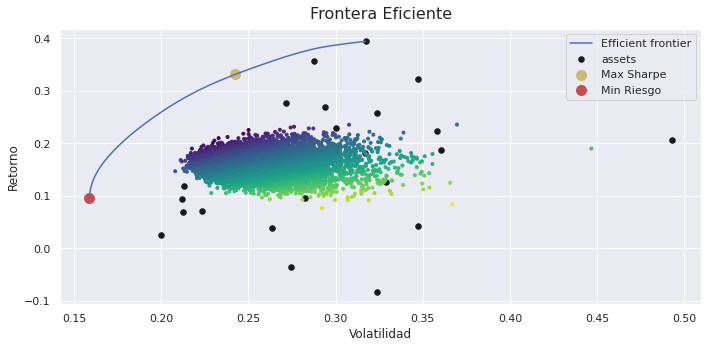

In [120]:
# Se volvio a declarar frontera_eficiente ya que cuando se realizan algunos calculos arriba la frontera cambia
frontera_eficiente = pypfopt.efficient_frontier.EfficientFrontier(retorno_esperado,riesgo, weight_bounds=(0,1))
# No se hizo mas grande por que arroja error por exceso de uso de ram 
fig, ax = plt.subplots(figsize = (10,5)) 
 # Cargamos la grafica donde se van a poner todos los puntos 
plotting.plot_efficient_frontier(frontera_eficiente, ax=ax, show_assets=True)

# Aqui volvemos a declar para poder correr lo  en la grafica 
maximo = frontera_eficiente.max_sharpe() 
ret_tangent, std_tangent, _ = frontera_eficiente.portfolio_performance()
# Se declara como queremos que se muestre en la grafica 
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="y", label="Max Sharpe") 

#Volvemos a declar la linea ya que con el uso de max.sharpe cambia el valor 
frontera_eficiente_minimo = pypfopt.efficient_frontier.EfficientFrontier(retorno_esperado,riesgo, weight_bounds=(0,1)) 
# Manda el mismo error si no detectara la frontera eficiente 
minimo = frontera_eficiente_minimo.min_volatility() 
ret_tangent, std_tangent, _ = frontera_eficiente_minimo.portfolio_performance()
# Se declara como queremos que se muestre en la grafica 
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="r", label="Min Riesgo") 

# El numero de puebras que se mantuvo bajo ya que cuando ponemos mas colab no aguanto
n_samples = 10000  
w = np.random.dirichlet(np.ones(len(retorno_esperado)), n_samples)
rets = w.dot(retorno_esperado) # Obtenemos rendimientos 
stds = np.sqrt(np.diag(w @ w.T )) # Obtenemos la desviacion estandar 
sharpes = rets / stds 
ax.scatter(stds,rets, marker=".", c=sharpes, cmap="viridis_r")


ax.set_ylabel("Retorno")
ax.set_xlabel("Volatilidad")
ax.set_title("Frontera Eficiente", fontsize=16, pad=10) # Titulo de la Tabla 
ax.legend() # Ponemos las leyendas en las graficas 
plt.tight_layout() 
plt.savefig("frontera_eficiente_scatter.png", dpi=800,) # Guardamos la imagen 
plt.show() # Mostramos la imagen 

# **Conclusiones y Explicaciones**

**¿Por que es necesario hacer un portafolio?** 

Pues... para arriesgarte sólo lo necesario. En otras palabras, para no poner todos los huevos en una misma canasta. (De lo contrario, si la canasta se cae se rompen todos los huevos).



En las siguientes líneas veremos ejemplos de portafolios: 
1) El primero maximiza el radio de Sharpe y es probablemente el que un profesional te diría que compres. 
2) Este portafolio, como su nombre lo indica, es el que menos fluctuaciones presentaría, el más "seguro". 
3) Portafolio con pesos iguales: decidiste repartir tu inversión en partes iguales para las empresas, ese es el resultado. 
4) Portafolio con un rendimiento específico de 16%, dejamos fijo ese valor para obtener su riesgo. 

**Portafolio de Sharpe**

In [121]:
frontera = pypfopt.efficient_frontier.EfficientFrontier(retorno_esperado,riesgo, weight_bounds=(0,1)) # Se volvió a declarar frontera_eficiente ya que cuando se realizan algunos cálculos arriba la frontera cambia
weights = frontera.max_sharpe()
cleaned_weights = frontera.clean_weights()
frontera.portfolio_performance(verbose=True)

Expected annual return: 33.1%
Annual volatility: 24.2%
Sharpe Ratio: 1.28


(0.3312405820484045, 0.24245428396024504, 1.2837083220993457)

**Portafolio de Minima Varianza**

In [122]:
frontera = pypfopt.efficient_frontier.EfficientFrontier(retorno_esperado,riesgo, weight_bounds=(0,1)) #Se volvi+o a declarar frontera_eficiente ya que cuando se realizan algunos cálculos arriba la frontera cambia
weights = frontera.min_volatility()
cleaned_weights = frontera.clean_weights()
frontera.portfolio_performance(verbose=True)

Expected annual return: 9.5%
Annual volatility: 15.9%
Sharpe Ratio: 0.47


(0.09496639590759517, 0.1588426205805967, 0.4719539103143746)

**Portafolio de Pesos Iguales**

Como son 29 acciones se obtendra el (1/29) de cada rendimiento de accion y desviacion estandar (riesgo)

In [123]:
data_frame_retorno["rendimiento%"] = data_frame_retorno.apply(lambda row: (row.retorno*1/29), axis=1)
data_frame_retorno["desv%"] = data_frame_retorno.apply(lambda row: (row.desviacion_estandar_anual*1/29), axis=1)
data_frame_retorno["sharpe%"] = data_frame_retorno.apply(lambda row: (row.sharpe_ratio*1/29), axis=1)


In [124]:
print("Expected annual return:",round(data_frame_retorno["rendimiento%"].sum()*100,2),"%")
print("Annual volatility:",round(data_frame_retorno["desv%"].sum()*100,2),"%")
print("Sharpe Ratio:",round(data_frame_retorno["sharpe%"].sum(),2))

Expected annual return: 16.0 %
Annual volatility: 28.98 %
Sharpe Ratio: 0.49


**Portafolio de Rendimiento Especifico**

El siguiente portafolio se forma dandole un rendimiento especifico (16%), ya que buscaremos hacer una comparacion entre un rendimiento sin buscar la eficiencia (en este caso fue el de Portafolio Pesos Iguales)  y otro que si 

In [125]:
frontera = pypfopt.efficient_frontier.EfficientFrontier(retorno_esperado,riesgo, weight_bounds=(0,1)) # Se volvió a declarar frontera_eficiente ya que cuando se realizan algunos cálculos arriba la frontera cambia
weights = frontera.efficient_return(.16) #Aqui ponemos que es 16% que es el mismo rendimiento que nos Portafolio de Pesos Iguales
cleaned_weights = frontera.clean_weights()
frontera.portfolio_performance(verbose=True)


Expected annual return: 16.0%
Annual volatility: 16.6%
Sharpe Ratio: 0.84


(0.15999999999999998, 0.16613224069022603, 0.842702171585389)

¿Que podemos concluir con estos 4 portafolios?
1. El portafolio de Sharpe te da un poquito mas del doble del rendimiento pero con menor riesgo comparando con Portafolio de pesos iguales 
2. El portafolio de rendimiento especifico (16%) que es el mismo rendimiento que obtenemos con portafolio de pesos iguales, tiene un menor riesgo y un mejor ratio de sharpe 
3. El portafolio de minima varianza (minimo riesgo) tiene un rendimiento inferior por 6.5% a comparacion de Portafolio de pesos iguales sin embargo este tiene casi el doble de riesgo 
4. La practica en general se busca que el ratio de Sharpe sea mayor a uno (aun que claro eso tambien depende del perfil de la persona) por lo que el unico que cumple con esto (de estos 4 selecionados) es el de Maxima de Sharpe (claro por claras razones) ya que esa combinacion de acciones (El DowJones) el maximo ratio de sharpe que pueden alcanzar es ese  

Pero las cosas se ven mejor graficadas

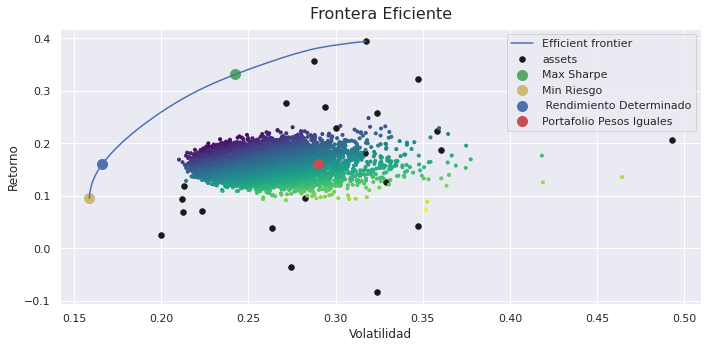

In [126]:
frontera_eficiente = pypfopt.efficient_frontier.EfficientFrontier(retorno_esperado,riesgo, weight_bounds=(0,1)) #Se volvio a declarar frontera_eficiente ya que cuando se realizan algunos calculos arriba la frontera cambia
fig, ax = plt.subplots(figsize = (10,5)) # No se hizo mas grande por que arroja error por exceso de uso de ram 
plotting.plot_efficient_frontier(frontera_eficiente, ax=ax, show_assets=True) #Cargamos la grafica donde se van a poner todos los puntos 

maximo = frontera_eficiente.max_sharpe() # Aqui volvemos a declar para poder correr lo  en la grafica 
ret_tangent, std_tangent, _ = frontera_eficiente.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="g", label="Max Sharpe") # Se declara como queremos que se muestre en la grafica 

frontera_eficiente_minimo = pypfopt.efficient_frontier.EfficientFrontier(retorno_esperado,riesgo, weight_bounds=(0,1)) # Volvemos a declar la linea ya que con el uso de max.sharpe cambia el valor 
minimo = frontera_eficiente_minimo.min_volatility()
ret_tangent, std_tangent, _ = frontera_eficiente_minimo.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="y", label="Min Riesgo") # Se declara como queremos que se muestre en la grafica 

frontera_eficiente_determinado = pypfopt.efficient_frontier.EfficientFrontier(retorno_esperado,riesgo, weight_bounds=(0,1)) # Volvemos a declar la linea ya que con el uso de min.sharpe cambia el valor 
determinado = frontera_eficiente_determinado.efficient_return(.16)
ret_tangent, std_tangent, _ = frontera_eficiente_determinado.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="o", s=100, c="b", label=" Rendimiento Determinado") # Se declara como queremos que se muestre en la grafica 

n_samples = 10000  # El numero de puebras que se mantuvo bajo ya que cuando ponemos mas colab no aguanto
w = np.random.dirichlet(np.ones(len(retorno_esperado)), n_samples) # A diferencia de la version en R esta paqueteria no tiene incluido Monte Carlo por lo que la documentacion nos recomienda este modelo 
rets = w.dot(retorno_esperado) # Obtenemos rendimientos 
stds = np.sqrt(np.diag(w @ w.T)) # Obtenemos la desviacion estandar 
sharpes = rets / stds 
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(.2898, .16 , marker="o", s=100, c="r", label="Portafolio Pesos Iguales") #Parametros de Portafolio iguales .2898 es = volatilidad anual y .16 = rendimiento 

ax.set_ylabel("Retorno")
ax.set_xlabel("Volatilidad")
ax.set_title("Frontera Eficiente", fontsize=16, pad=10) # Titulo de la Tabla 
ax.legend() # Ponemos las leyendas en las graficas 
plt.tight_layout() 
plt.savefig("frontera_eficiente_scatter1.png", dpi=800,) # Guardamos la imagen 
plt.show() # Mostramos la imagen 

Aqui podemos ver el portafolio de Pesos Iguales, solo para recordar los datos del eje x = Volatilidad que es igual a Riesgo y el eje de las y = Rendimiento 


Entonces recordemos que el rendimiento determinado lo pusimos por el rendimiento que nos dio el Portafolio de Pesos Iguales, en esta grafica se puede ver claramente lo importante que es optar por un portafolio de la frontera eficiente, el riesgo de Portafolio de Pesos Iguales es sumamente grande por el rendimiento que te da.

Una vez que ya sabes cuales es el portafolio ideal para el riesgo admitido, lo exploraremos mas al fondo para poder ver todas sus caracteristicas 

**Por nuestro perfil de inversion nuestro equipo elegimos el portafolio optimo segun Sharpe** 

In [127]:
#Aqui se encuentra la ponderacion del portafolio 
sharpe_ponderacion 

OrderedDict([('PG', 0.0),
             ('CSCO', 0.0),
             ('AXP', 0.0),
             ('UNH', 0.0),
             ('MMM', 0.0),
             ('CRM', 0.0),
             ('IBM', 0.0),
             ('DIS', 0.0),
             ('WMT', 0.14337),
             ('KO', 0.0),
             ('JNJ', 0.0),
             ('HON', 0.0),
             ('MCD', 0.0),
             ('VZ', 0.0),
             ('CAT', 0.02916),
             ('GS', 0.0),
             ('INTC', 0.0),
             ('MRK', 0.0),
             ('V', 0.0),
             ('NKE', 0.13929),
             ('HD', 0.0),
             ('AAPL', 0.36583),
             ('TRV', 0.0),
             ('WBA', 0.0),
             ('JPM', 0.0),
             ('AMGN', 0.0),
             ('MSFT', 0.32236),
             ('CVX', 0.0),
             ('BA', 0.0)])

In [128]:
# Filtramos para poder tener solamente las acciones que tuvieran un % en el portafolio 
portafolio_de_sharpe = dict(filter(lambda x: x[1] > .001, sharpe_ponderacion.items())) 
portafolio_de_sharpe

{'AAPL': 0.36583,
 'CAT': 0.02916,
 'MSFT': 0.32236,
 'NKE': 0.13929,
 'WMT': 0.14337}

In [129]:
# Filtro para poder utilizar solo nombre de las acciones del portafolio 
filtro_sharpe = list(portafolio_de_sharpe.keys())
filtro_sharpe

['WMT', 'CAT', 'NKE', 'AAPL', 'MSFT']

In [130]:
# Filtro para poder utilizar solo los porcentajes del portafolio 
filtro_sharpe_valores = list(portafolio_de_sharpe.values())

filtro_sharpe_valores

[0.14337, 0.02916, 0.13929, 0.36583, 0.32236]

In [131]:
# Llamamos a la API para poder obtener los datos limpias de nuestras acciones 
obtener_datos_sharpe = pdr.get_data_yahoo(filtro_sharpe, start="2017-01-01", end="2021-03-05") # Por la comparacion de metologias utilizaremos fechas fijas
obtener_datos_sharpe

Attributes   Adj Close              ...       Volume            
Symbols            WMT         CAT  ...         AAPL        MSFT
Date                                ...                         
2017-01-03   62.520519   83.425034  ...  115127600.0  20694100.0
2017-01-04   62.884735   83.052246  ...   84472400.0  21340000.0
2017-01-05   63.021332   82.546333  ...   88774400.0  24876000.0
2017-01-06   62.156273   82.581802  ...  127007600.0  19922900.0
2017-01-09   62.566029   81.987137  ...  134247600.0  20382700.0
...                ...         ...  ...          ...         ...
2021-03-01  130.312027  218.771088  ...  116307900.0  25324000.0
2021-03-02  129.062180  214.848816  ...  102260900.0  22812500.0
2021-03-03  126.562462  213.942917  ...  112966300.0  34029500.0
2021-03-04  126.502953  211.812546  ...  178155000.0  44727800.0
2021-03-05  128.080139  219.169296  ...  153766600.0  41872800.0

[1050 rows x 30 columns]

In [132]:
# Obtenemos solo la columna de cierre de dia 
sharpe_cierre = obtener_datos_sharpe["Close"]
sharpe_cierre

Symbols            WMT         CAT         NKE        AAPL        MSFT
Date                                                                  
2017-01-03   68.660004   93.989998   51.980000   29.037500   62.580002
2017-01-04   69.059998   93.570000   53.070000   29.004999   62.299999
2017-01-05   69.209999   93.000000   53.060001   29.152500   62.299999
2017-01-06   68.260002   93.040001   53.910000   29.477501   62.840000
2017-01-09   68.709999   92.370003   53.380001   29.747499   62.639999
...                ...         ...         ...         ...         ...
2021-03-01  131.369995  219.759995  137.649994  127.790001  236.940002
2021-03-02  130.110001  215.820007  137.020004  125.120003  233.869995
2021-03-03  127.589996  214.910004  134.259995  122.059998  227.559998
2021-03-04  127.529999  212.770004  132.039993  120.129997  226.729996
2021-03-05  129.119995  220.160004  133.350006  121.419998  231.600006

[1050 rows x 5 columns]

In [133]:
rendimiento_datos_sharpe = pypfopt.expected_returns.returns_from_prices(sharpe_cierre) #Obtenemos los rendimientos diarios 


**Multiplicaremos los rendimientos por la porcion en la que pertenece al portafolio** 

In [134]:
# Multiplicamos por la ponderacion que le corresponde a cada accion por el rendimiendo de la accion, lo que nos dara el rendimiento ponderado de cada accion 
rendimiento_datos_sharpe["WMT"] = rendimiento_datos_sharpe["WMT"]*filtro_sharpe_valores[0]
rendimiento_datos_sharpe["CAT"] = rendimiento_datos_sharpe["CAT"]*filtro_sharpe_valores[1]
rendimiento_datos_sharpe["NKE"] = rendimiento_datos_sharpe["NKE"]*filtro_sharpe_valores[2]
rendimiento_datos_sharpe["AAPL"] = rendimiento_datos_sharpe["AAPL"]*filtro_sharpe_valores[3]
rendimiento_datos_sharpe["MSFT"] = rendimiento_datos_sharpe["MSFT"]*filtro_sharpe_valores[4]

In [135]:
# Multiplicamos por la ponderacion que le corresponde a cada accion por el precio de la accion, lo que nos dara el precio ponderado de cada accion 

sharpe_cierre["WMT"] = sharpe_cierre["WMT"]*filtro_sharpe_valores[0]
sharpe_cierre['CAT'] = sharpe_cierre["CAT"]*filtro_sharpe_valores[1]
sharpe_cierre['NKE'] = sharpe_cierre["NKE"]*filtro_sharpe_valores[2]
sharpe_cierre['AAPL'] = sharpe_cierre["AAPL"]*filtro_sharpe_valores[3]
sharpe_cierre['MSFT'] = sharpe_cierre["MSFT"]*filtro_sharpe_valores[4]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [136]:
# Sumaremos los precios ya que por el codigo de arriba ya estan ponderados y la suma de todos es = al 100%
cierre_precios_portafolio_sharpe = sharpe_cierre["WMT"]+sharpe_cierre['CAT']+sharpe_cierre['NKE']+sharpe_cierre['AAPL']+sharpe_cierre['MSFT']

In [137]:
# Resultado del portafolio 
cierre_precios_portafolio_sharpe 

Date
2017-01-03     50.620905
2017-01-04     50.715680
2017-01-05     50.773132
2017-01-06     51.049463
2017-01-09     51.054920
                 ...    
2021-03-01    167.545381
2021-03-02    165.195681
2021-03-03    161.269878
2021-03-04    159.916038
2021-03-05    162.583778
Length: 1050, dtype: float64

**Portafolio** 

In [138]:
# Sumaremos los rendimientos ya que por el codigo de arriba ya estan ponderados y la suma de todos es igual al 100%
portafolio_junto_sharpe = (rendimiento_datos_sharpe["WMT"]+rendimiento_datos_sharpe["CAT"]+rendimiento_datos_sharpe["NKE"]+rendimiento_datos_sharpe["AAPL"]+rendimiento_datos_sharpe["MSFT"])

In [139]:
portafolio_junto_sharpe

Date
2017-01-04    0.001774
2017-01-05    0.001968
2017-01-06    0.007148
2017-01-09    0.001691
2017-01-10   -0.000979
                ...   
2021-03-01    0.031116
2021-03-02   -0.014356
2021-03-03   -0.023350
2021-03-04   -0.009621
2021-03-05    0.015035
Length: 1049, dtype: float64

**Metricas con la ponderacion del portafolio**

**Promedio**

In [140]:
portafolio_junto_sharpe.mean() # Rendimiento promedio diario por el porcentaje del portafolio 

0.0013076992611285524

In [141]:
portafolio_junto_sharpe.mean()*30 # Rendimiento promedio mensual por el porcentaje del portafolio 

0.039230977833856574

**Media**

In [142]:
portafolio_junto_sharpe.sort_values().median() #Acomodamos los precios de mayor a menor y sacamos la mediana mensual

0.0018726196358175267

**Media Truncada**

In [143]:

stats.trim_mean(portafolio_junto_sharpe, 0.1) #Quitando el 10% en extremos curiosamente tenemos un promedio mas grande 

0.0016305555727942347

**Desviacion Estandar** 

In [144]:
portafolio_junto_sharpe.std() #Desviacion estandar diaria

0.015190206959921739

**Graficamente podemos notar como los datos en general se tiran mas a la izquierda (ganancia)** 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



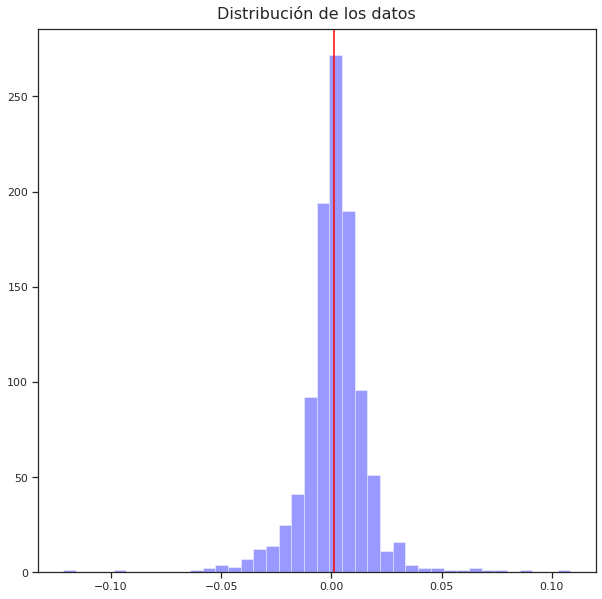

In [145]:
fig = plt.figure(figsize=(10,10))

sns.set(style='ticks')
ax = sns.distplot(portafolio_junto_sharpe, kde=False, norm_hist=False, bins=40, color="blue")
ax.set_title("Distribución de los datos", fontsize=16, pad=10)
plt.axvline(portafolio_junto_sharpe.mean(), c='red');

**Mostramos el histograma por accion** 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



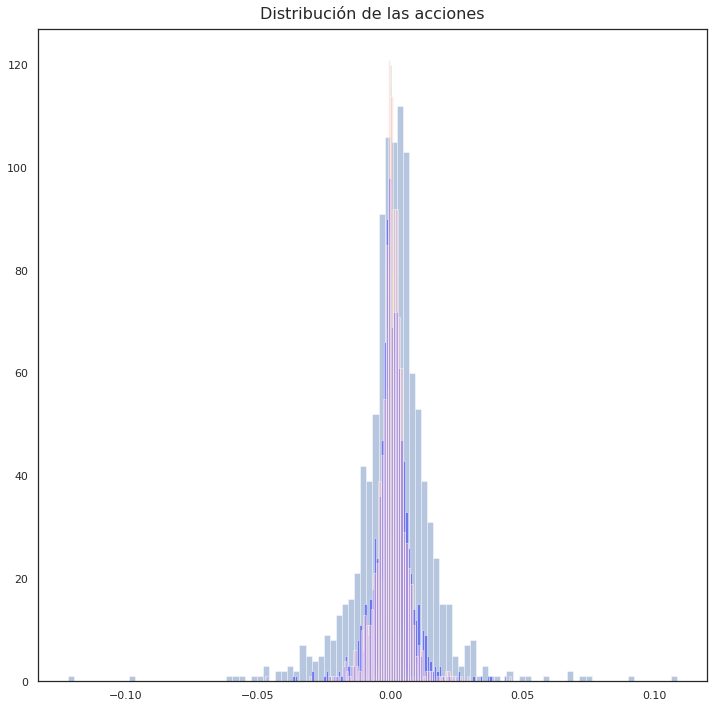

In [146]:
fig = plt.figure(figsize=(12,12))
sns.set(style='white')

ax = sns.distplot(portafolio_junto_sharpe, kde=False,norm_hist=False, bins=100, kde_kws = {'shade': True} )
sns.distplot(rendimiento_datos_sharpe["WMT"], kde=False, norm_hist=False, bins=100, kde_kws = {'shade': True}, color="orange")
sns.distplot(rendimiento_datos_sharpe["CAT"], kde=False,  norm_hist=False, bins=100, kde_kws = {'shade': True}, color="red")
sns.distplot(rendimiento_datos_sharpe["NKE"], kde=False,  norm_hist=False, bins=100, kde_kws = {'shade': True}, color="green")
sns.distplot(rendimiento_datos_sharpe["AAPL"], kde=False, norm_hist=False, bins=100, kde_kws = {'shade': True}, color="blue")
sns.distplot(rendimiento_datos_sharpe["MSFT"],kde=False ,norm_hist=False, bins=100, kde_kws = {'shade': True} , color="pink");

ax.set_xlabel("")
ax.set_title("Distribución de las acciones", fontsize=16, pad=10);

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



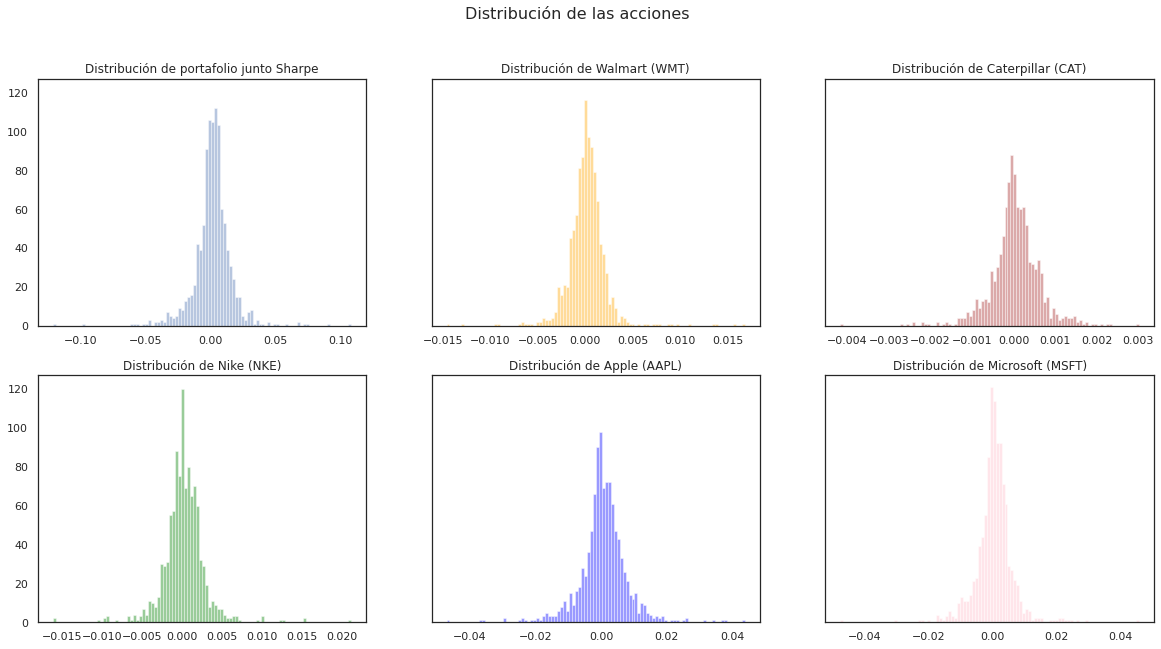

In [147]:
fig, axes = plt.subplots(2,3, figsize=(20,10), sharey=True, sharex=False)
sns.set(style='white')

sns.distplot(portafolio_junto_sharpe, kde=False,norm_hist=False, bins=100, kde_kws = {'shade': True}, ax=axes[0,0])
sns.distplot(rendimiento_datos_sharpe["WMT"], kde=False, norm_hist=False, bins=100, kde_kws = {'shade': True}, color="orange", ax=axes[0,1])
sns.distplot(rendimiento_datos_sharpe["CAT"], kde=False,  norm_hist=False, bins=100, kde_kws = {'shade': True}, color="brown", ax=axes[0,2])
sns.distplot(rendimiento_datos_sharpe["NKE"], kde=False,  norm_hist=False, bins=100, kde_kws = {'shade': True}, color="green", ax=axes[1,0])
sns.distplot(rendimiento_datos_sharpe["AAPL"], kde=False, norm_hist=False, bins=100, kde_kws = {'shade': True}, color="blue", ax=axes[1,1])
sns.distplot(rendimiento_datos_sharpe["MSFT"],kde=False ,norm_hist=False, bins=100, kde_kws = {'shade': True}, color="pink", ax=axes[1,2])

axes[0,0].set(xlabel="", ylabel="", title="Distribución de portafolio junto Sharpe")
axes[0,1].set(xlabel="", ylabel="", title="Distribución de Walmart (WMT)")
axes[0,2].set(xlabel="", ylabel="", title="Distribución de Caterpillar (CAT)")
axes[1,0].set(xlabel="", ylabel="", title="Distribución de Nike (NKE)")
axes[1,1].set(xlabel="", ylabel="", title="Distribución de Apple (AAPL)")
axes[1,2].set(xlabel="", ylabel="", title="Distribución de Microsoft (MSFT)")

fig.suptitle("Distribución de las acciones", fontsize=16);

Linea de Tendencia de Nuestra Combinacion de Portafolio 

**En estas dos graficas son importantes, por que ?, la razon es que la primera es la de nuestro portafolio y la segunda es la del indice en el que estan las  acciones que adquirimos
Si observamos bien logramos "aplanar" la grafica, podemos distinguir que nuestro portafolio no hubiera teniando rendimientos tan altos, sin embargo tampoco bajadas tan abruptas.**

"Lo importante no es poner varios huevos en una canasta, lo importante es agarrar los huevo de oro"

Text(0, 0.5, 'Rendimiento portafolio')

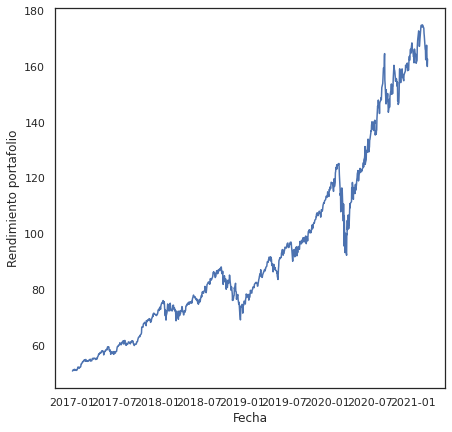

In [148]:
fig = plt.figure(figsize=(7,7))
sns.set(style='white')

sns.lineplot(data = cierre_precios_portafolio_sharpe);

plt.xlabel('Fecha')
plt.ylabel('Rendimiento portafolio')

Cargaremos el Indice DowJones e IPC

In [151]:
dji = pdr.get_data_yahoo("^DJI", start="2017-01-01", end="2021-03-05") # Por la comparacion de metologias utilizaremos fechas fijas

In [152]:
dji_close = dji["Close"]

Text(0, 0.5, 'Rendimiento DJI')

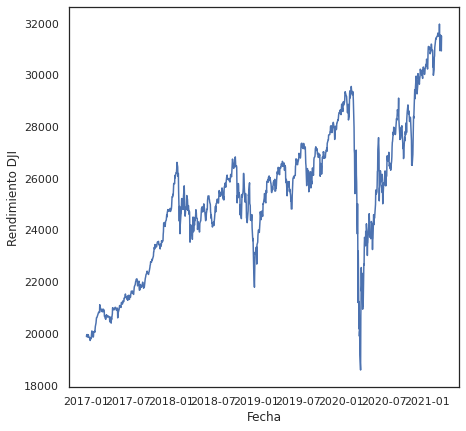

In [153]:
fig = plt.figure(figsize=(7,7))
sns.set(style='white')

sns.lineplot(data = dji_close);

plt.xlabel('Fecha')
plt.ylabel('Rendimiento DJI')

Ahora haremos una regresion Lineal para comparada el DowJones y Nuestro Portafolio

In [154]:
 dji_close_rendimiento = pypfopt.expected_returns.returns_from_prices(dji_close) # Para poder hacer la comparacion, vamos a compara precio y rendimiento 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Dow Jones')

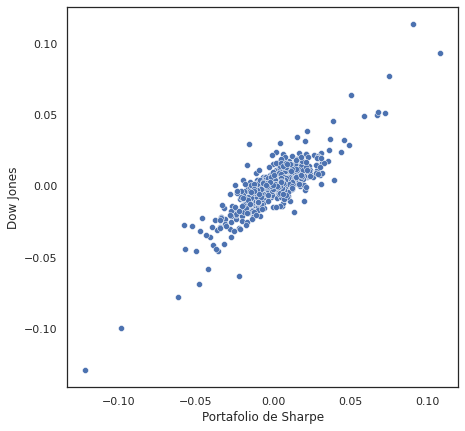

In [159]:
fig = plt.figure(figsize=(7,7))
sns.set(style='white')

sns.scatterplot(portafolio_junto_sharpe, dji_close_rendimiento); # Podemos distinguir que se ve cierta correlacion entre rendimientos y que la mayoria se encuentran en un punto
plt.xlabel('Rendimiento portafolio de Sharpe')
plt.ylabel('Rendimiento DJI')

In [ ]:
 #Aqui podemos notar lo que vemos en la grafica, la alta correlacion que existe entre DowJones y Nuestro Portafolio (que seria algo de esperar)
#Sin embargo hay que recaltar no solamente que el portafolio se parece al DowJones si no que es mejor (hablando en cuestion de volatilidad/rendimiento)
portafolio_junto_sharpe.corr(dji_close_rendimiento)

0.8505580015608482

Empezar a tratar de predecir el DowJones con nuestro portafolio

In [172]:
lr = LinearRegression()

In [173]:
lr.fit(portafolio_junto_sharpe.to_frame(), dji_close_rendimiento) # Ponemos las variables 
y_prediccion_rendimientos = lr.predict(portafolio_junto_sharpe.to_frame()) # Entrenamos el "predictor" 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Rendimiento de DJI')

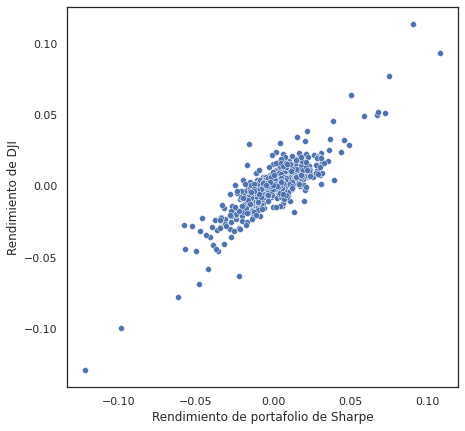

In [182]:
fig = plt.figure(figsize= (7,7))
sns.set_style('white')

sns.scatterplot(portafolio_junto_sharpe, dji_close_rendimiento); # Mostramos grafica del plot de rendimiento 

plt.xlabel('Rendimiento de portafolio de Sharpe')
plt.ylabel('Rendimiento de DJI')


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Predicción de rendimientos')

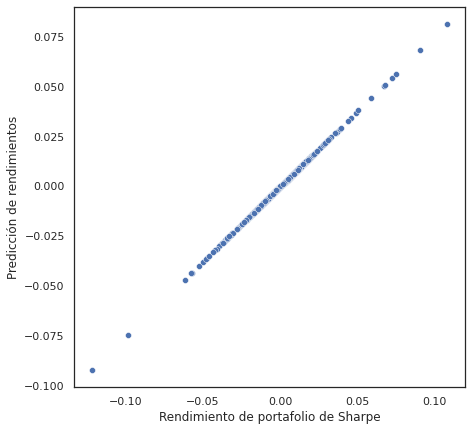

In [183]:
fig = plt.figure(figsize=(7,7))
sns.set_style('white')

sns.scatterplot(portafolio_junto_sharpe, y_prediccion_rendimientos);

plt.xlabel('Rendimiento de portafolio de Sharpe')
plt.ylabel('Predicción de rendimientos')

Ahora hagamos una comparacion con los precios 

In [177]:
cierre_precios_portafolio_sharpe.corr(dji_close) # Correlacion alta 

0.8140826952604374

In [178]:
lr.fit(cierre_precios_portafolio_sharpe.to_frame(), dji_close)  # Ponemos las variables 
y_prediccion_precios_cierre = lr.predict(cierre_precios_portafolio_sharpe.to_frame()) # Entrenamos el "predictor"

La siguiente grafica pareceria como si fueran 2 graficas distintas en donde a cada una se le puede notar cierta correlacion lineal, esa diferencia tiene que con el COVID ya que rompio una tendencia 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 0.5, 'Precios de cierre DJI')

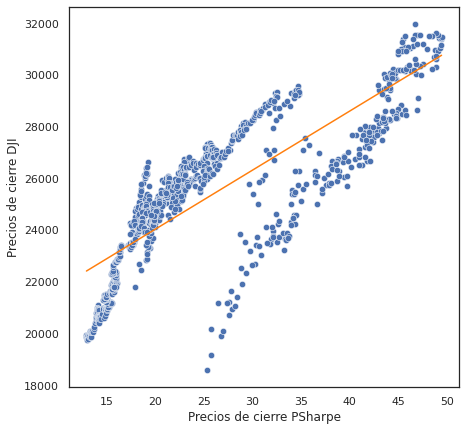

In [191]:
fig = plt.figure(figsize=(7,7))
sns.scatterplot(cierre_precios_portafolio_sharpe, dji_close, s = 40); 
sns.lineplot(cierre_precios_portafolio_sharpe, y_prediccion_precios_cierre, color='#FF7F0E');
plt.xlabel('Precios de cierre PSharpe')
plt.ylabel('Precios de cierre DJI')

Aqui se pueden ver el error estandar como podemos notar existe demasiado error estandar en los picos del COVID por que son muy atipicos 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



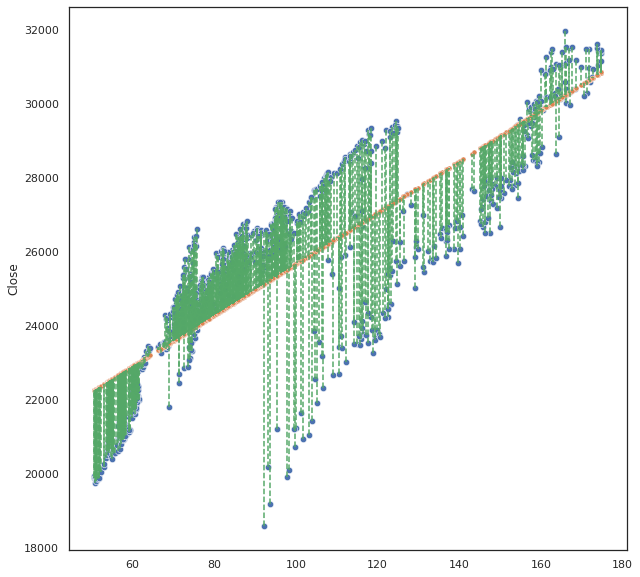

In [ ]:
sns.scatterplot(cierre_precios_portafolio_sharpe, dji_close, s = 40);
sns.scatterplot(cierre_precios_portafolio_sharpe, y_prediccion_precios_cierre, s=25);

for i in range(len(cierre_precios_portafolio_sharpe)):
    plt.plot([cierre_precios_portafolio_sharpe[i], cierre_precios_portafolio_sharpe[i]], [dji_close[i], y_prediccion_precios_cierre[i]], 'g--')

In [204]:
intercept = lr.intercept_
coefficient = lr.coef_[0]

In [205]:
print(f'y = {coefficient} * x + {intercept}') # Ecuacion Predictor de DowJones 

y = 227.92373077469432 * x + 19480.286889262126


In [206]:
def regresion_lineal(x):
    return 69.3078198211811 * x + 18740.872630857884

In [208]:
print(f'R2: {np.power(cierre_precios_portafolio_sharpe.corr(dji_close), 2)}')


R2: 0.6627306347224983


In [207]:
regresion_lineal(190) # Ejemplo, si nuestro portafolio vale 190 dólares, el DowJones tendria un aproximado de valor del 31909 dólares, con un márgen de 
# de ~33% y predictividad de %70

31909.358396882293

#**AHORA SÍ, MACHINE LEARNING**#

Lo que haremos a continuación es comprobar que nuestro portafolio es capaz de actuar como un amortiguador de los movimientos bruscos de la bolsa, tomando como modelo el índice de Dow Jones. 
No creemos que podamos predecir la bolsa con machine learning, porque la economía es algo muy humano, que incluso hasta los tweets de una persona famosa tienen influencia. Pero sí que podemos usar las técnicas de machine learning para tomar una decisión más informada sobre la compra de acciones. 

In [ ]:
df_cierre_precios_portafolio_sharpe = pd.DataFrame(cierre_precios_portafolio_sharpe)
df_cierre_precios_portafolio_sharpe = df_cierre_precios_portafolio_sharpe.reset_index(drop=True)
Y = df_cierre_precios_portafolio_sharpe[0]
Y

0       12.888921
1       12.884487
2       12.906632
3       13.003240
4       13.016988
          ...    
1045    47.282001
1046    46.564176
1047    45.392820
1048    45.002150
1049    45.745247
Name: 0, Length: 1050, dtype: float64

In [ ]:
df_dji_close = pd.DataFrame(dji_close)
df_dji_close = df_dji_close.reset_index(drop=True)
X = df_dji_close["Close"]
X

0       19881.759766
1       19942.160156
2       19899.289062
3       19963.800781
4       19887.380859
            ...     
1045    31535.509766
1046    31391.519531
1047    31270.089844
1048    30924.140625
1049    31496.300781
Name: Close, Length: 1050, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X_train, X_test, y_train, y_test = train_test_split(X.to_frame(), Y, test_size=0.30)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_predict = lr.predict(X_test)

print("\nPrediction score: ", lr.score(X_test, y_test))
error = mean_squared_error(y_test, y_predict)
print("Mean squared error: ", error, "\n\n")

df_predicciones = pd.DataFrame({'valor_real':y_test, 'prediccion':y_predict, 'diferencia':y_test - y_predict})
df_predicciones = df_predicciones.reset_index(drop = True)
print(df_predicciones)


Prediction score:  0.6215768940201559
Mean squared error:  33.68022979679784 


     valor_real  prediccion  diferencia
0     15.981894   18.366011   -2.384117
1     16.308746   19.326967   -3.018221
2     14.627636   12.810003    1.817633
3     49.064887   43.915678    5.149208
4     14.861841   14.185682    0.676159
..          ...         ...         ...
310   41.050643   33.272707    7.777936
311   15.505247   15.326270    0.178977
312   15.069432   12.925347    2.144085
313   22.757811   28.323161   -5.565350
314   44.200974   39.641936    4.559038

[315 rows x 3 columns]


In [ ]:
df_portafolio_junto_sharpe = pd.DataFrame(portafolio_junto_sharpe)
df_portafolio_junto_sharpe = df_portafolio_junto_sharpe.reset_index(drop=True)
Y = df_portafolio_junto_sharpe[0]
Y

0       0.001774
1       0.001968
2       0.007148
3       0.001691
4      -0.000979
          ...   
1044    0.031116
1045   -0.014356
1046   -0.023350
1047   -0.009621
1048    0.015035
Name: 0, Length: 1049, dtype: float64

In [ ]:
df_dji_close_rendimiento = pd.DataFrame(dji_close_rendimiento)
df_dji_close_rendimiento = df_dji_close_rendimiento.reset_index(drop=True)
X = df_dji_close_rendimiento["Close"]
X

0       0.003038
1      -0.002150
2       0.003242
3      -0.003828
4      -0.001602
          ...   
1044    0.019499
1045   -0.004566
1046   -0.003868
1047   -0.011063
1048    0.018502
Name: Close, Length: 1049, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X_train, X_test, y_train, y_test = train_test_split(X.to_frame(), Y, test_size=0.30)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_predict = lr.predict(X_test)

print("\nPrediction score: ", lr.score(X_test, y_test))
error = mean_squared_error(y_test, y_predict)
print("Mean squared error: ", error, "\n\n")

df_predicciones = pd.DataFrame({'valor_real':y_test, 'prediccion':y_predict, 'diferencia':y_test - y_predict})
df_predicciones = df_predicciones.reset_index(drop = True)
print(df_predicciones)


Prediction score:  0.7433684529831377
Mean squared error:  6.40505107993845e-05 


     valor_real  prediccion  diferencia
0      0.010017   -0.003121    0.013138
1      0.011484    0.005144    0.006341
2      0.011572    0.009441    0.002131
3      0.003615    0.004754   -0.001139
4      0.030577    0.013600    0.016978
..          ...         ...         ...
310    0.059227    0.046866    0.012361
311   -0.012417   -0.000994   -0.011423
312   -0.001785    0.002851   -0.004636
313    0.000204   -0.001610    0.001814
314    0.004656    0.003508    0.001148

[315 rows x 3 columns]


#**EXTRA**#

##Análisis de sentimientos del grupo de WallStreetbets en reddit##

In [211]:
#Primero ocupamos cargar nuestro dataframe de GoogleDrive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [212]:
#Autenticamos al usuario y agregamos un cliente de PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [213]:
fileDownloaded = drive.CreateFile({'id':'1FuzsrYGYz6_hUIYW6j12NLFaiKBrlEbv'})

In [214]:
fileDownloaded.GetContentFile('reddit_wsb.csv')

In [215]:
df = pd.read_csv('reddit_wsb.csv')

df.head()

title  ...            timestamp
0  It's not about the money, it's about sending a...  ...  2021-01-28 21:37:41
1  Math Professor Scott Steiner says the numbers ...  ...  2021-01-28 21:32:10
2                                    Exit the system  ...  2021-01-28 21:30:35
3  NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...  ...  2021-01-28 21:28:57
4  Not to distract from GME, just thought our AMC...  ...  2021-01-28 21:26:56

[5 rows x 8 columns]

In [216]:
#Primero queremos usar solo los posts del año 2021 
r_data = df[pd.to_datetime(df['timestamp']).dt.year>=2021]
#Parece que solo hay una opinión de un año que no es 2021

In [217]:
# Nos quedaremos solo con los títulos, ya que reflejan el mensaje principal de la opinión de los usuarios 
title_data = r_data[['title', 'timestamp']].copy()
title_data = title_data.dropna()

In [218]:
#Debido a que el texto tiene mayúsculas y minúsculas, pasaremos todo a minúsculas para mayor homogeneidad
title_data.title = title_data.title.str.lower() 

In [219]:
#removiendo handlers
title_data.title = title_data.title.apply(lambda x:re.sub('@[^\s]+', '', x))

In [220]:
#removiendo urls
title_data.title = title_data.title.apply(lambda x:re.sub(r"http\S+", "", x))

In [221]:
#removiendo single characters 
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

In [222]:
#sustituyendo espacios múltiples con un solo espacio 
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [223]:
#removiendo tiempo de timestamp 
title_data.timestamp = pd.to_datetime(title_data.timestamp).dt.date 

Utilizamos la librería SIA que asigna un puntaje a las palabras de acuerdo a qué tan positivas o negativas son 

In [224]:
sid = SIA()
title_data['sentiments'] = title_data['title'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

In [225]:
title_data['Positive Sentiment'] = title_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6))
title_data['Neutral Sentiment'] = title_data['sentiments'].apply(lambda x: x['neu']+1*((10**-6)))
title_data['Negative Sentiment'] = title_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
title_data.drop(columns=['sentiments'], inplace=True)
title_data = title_data.rename(columns={'timestamp': 'date'})

In [226]:
title_data.head()

title  ... Negative Sentiment
0  it's not about the money, it's about sendingme...  ...           0.000001
1  math professor scott steiner says the numbers ...  ...           0.272001
2                                    exit the system  ...           0.000001
3  new sec filing for gme! can someone less retar...  ...           0.204001
4  not to distract from gme, just thought our amc...  ...           0.000001

[5 rows x 5 columns]

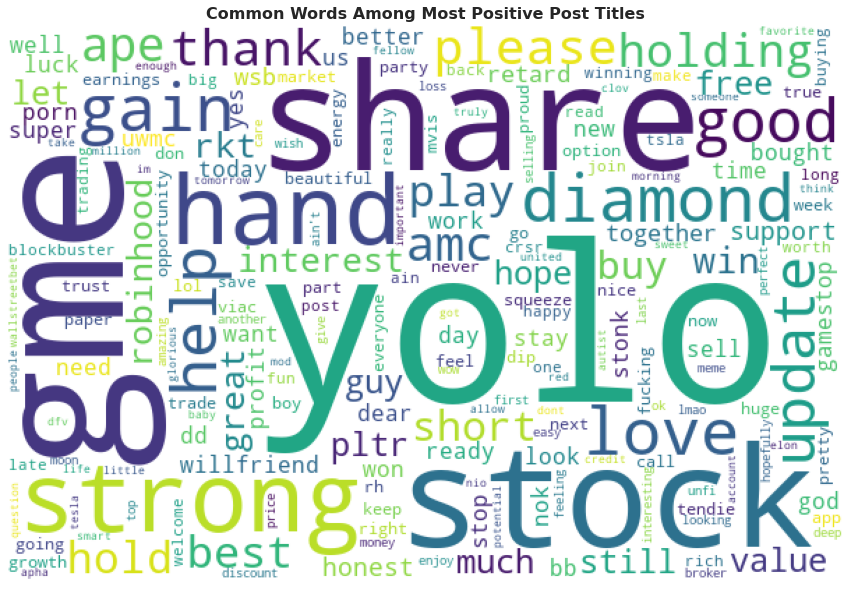

In [227]:

Most_Positive = title_data[title_data['Positive Sentiment'].between(0.4,1)]['title']

Most_Positive_text = ' '.join(Most_Positive)
pwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Positive_text)

plt.figure(figsize=(15,15))
plt.title('Common Words Among Most Positive Post Titles',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')

plt.show()

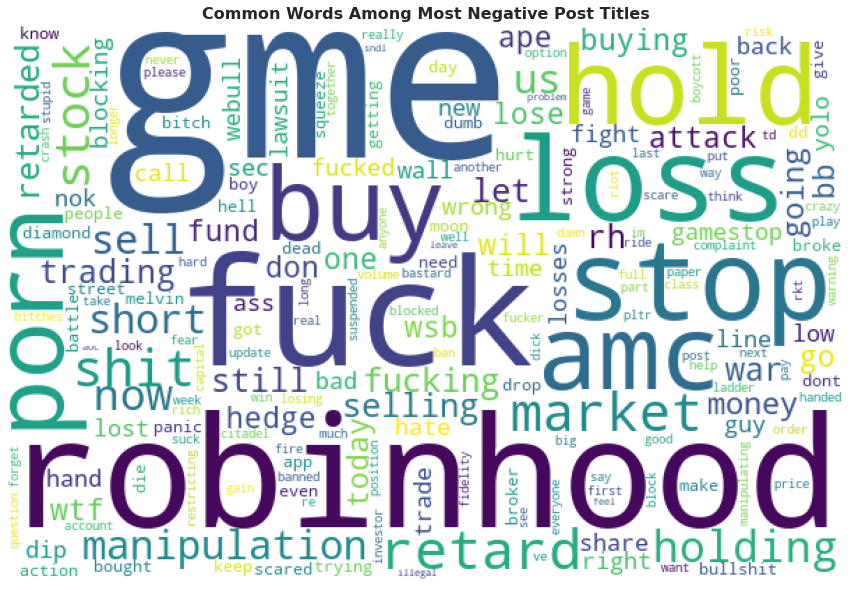

In [ ]:
Most_Negative = title_data[title_data['Negative Sentiment'].between(0.25,1)]['title']
Most_Negative_text = ' '.join(Most_Negative)
nwc = WordCloud(width=600,height=400,collocations = False,background_color='white').generate(Most_Negative_text)
plt.figure(figsize=(15,15))
plt.title('Common Words Among Most Negative Post Titles',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()


# **Conclusion en General**
Bueno ¿Que aprendimos? que el 2018 fue el año con peor en rendimiento que el mismo coronavirus; aunque si tuvo la caida mas grande, sin embargo no tardo en levantarse, ¿Entonces podemos concluir que estar peleando con China es mas perjucial para USA que mantener a toda su poblacion encerrada? Hay que recordar que China es la fabrica del Planeta, tambien vimos cual es la accion mas rentable y tambien curiosamente es la accion que mas Ratio de Sharpe da por lo que APPLE podemos considerar como una empresas bastante fuerte, claro tiene tanto dinero que en USA ya tienen su propia tarjetas de credito.
Respecto a los portafolios creo que ya se demostro que cuando se trata de poder selecionar las mejores acciones es bueno darle un vistaso a la Frontera Eficiente de Markowitz, sin embargo no es la forma mas moderna de hacerlo ya que existe otro modelos uno igual de popular llamado CAPM que es un modelo que se creo para cubrir las "debilidades del modelo de Markowitz", tambien no solo es seleccionar acciones, hay un famoso invercionista que dice "La verdadera ganancia se encuentra en la compra no en las venta", ¿que quiere decir esto? en pocas palabras es mas eficiente enfocarse en la compra ya que si compraste inteligentemente la ganancia "esta asegurada"